# Loading packages

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import os
import scipy
from scipy.stats import shapiro, ttest_1samp, ttest_ind, ttest_rel, f, bartlett, levene
from scipy.optimize import minimize
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import datetime
import time
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import copy
from tabulate import tabulate

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (50,10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

# Chapter 1
# Introduction
Code for the Introduction, with explorative analysis and the definitions of temp+ and temp-

# Loading the dataset

In [2]:
# loading the dataset
data = pd.read_excel('Thesis_Dataset.xlsx', sheet_name=None, index_col=0)

In [3]:
# Making a copy of the dataset since the loading takes some time
data_edit = copy.deepcopy(data)

# Select a store
to use as main example. To see the results for other stores, change the value in the following cell.

In [6]:
città = 'store_3'

datacittà = data_edit[città].dropna()

# Here we see the dataset for the store selected

In [7]:
datacittà

date  year  month  week  y_day  m_day  w_day  hour  \
2016-01-01 00:00:00 2016-01-01  2016      1     0      1      1      5     0   
2016-01-01 01:00:00 2016-01-01  2016      1     0      1      1      5     1   
2016-01-01 02:00:00 2016-01-01  2016      1     0      1      1      5     2   
2016-01-01 03:00:00 2016-01-01  2016      1     0      1      1      5     3   
2016-01-01 04:00:00 2016-01-01  2016      1     0      1      1      5     4   
...                        ...   ...    ...   ...    ...    ...    ...   ...   
2019-12-31 19:00:00 2019-12-31  2019     12    52    365     31      2    19   
2019-12-31 20:00:00 2019-12-31  2019     12    52    365     31      2    20   
2019-12-31 21:00:00 2019-12-31  2019     12    52    365     31      2    21   
2019-12-31 22:00:00 2019-12-31  2019     12    52    365     31      2    22   
2019-12-31 23:00:00 2019-12-31  2019     12    52    365     31      2    23   

                        kWh    m3  cust   emp  temp  M_temp  m_temp season  \
2016-01-01 00:00:00  13.968  8152   0.0  0.00   1.7     5.5    -3.0    inv   
2016-01-01 01:00:00  13.718  8152   0.0  0.00   1.7     5.5    -3.0    inv   
2016-01-01 02:00:00  13.459  8152   0.0  0.00   1.7     5.5    -3.0    inv   
2016-01-01 03:00:00  13.373  8152   0.0  0.00   1.7     5.5    -3.0    inv   
2016-01-01 04:00:00  13.248  8152   0.0  0.00   1.7     5.5    -3.0    inv   
...                     ...   ...   ...   ...   ...     ...     ...    ...   
2019-12-31 19:00:00  34.963  8152   1.0  1.00   3.5    10.3    -0.9    inv   
2019-12-31 20:00:00  31.852  8152   0.5  1.00   3.5    10.3    -0.9    inv   
2019-12-31 21:00:00  24.826  8152   0.0  1.00   3.5    10.3    -0.9    inv   
2019-12-31 22:00:00  20.141  8152   0.0  1.00   3.5    10.3    -0.9    inv   
2019-12-31 23:00:00  19.431  8152   0.0  0.25   3.5    10.3    -0.9    inv   

                     error  led  pvp  BMS  
2016-01-01 00:00:00      0  0.0    0    0  
2016-01-01 01:00:00      0  0.0    0    0  
2016-01-01 02:00:00      0  0.0    0    0  
2016-01-01 03:00:00      0  0.0    0    0  
2016-01-01 04:00:00      0  0.0    0    0  
...                    ...  ...  ...  ...  
2019-12-31 19:00:00      0  1.0    0    1  
2019-12-31 20:00:00      0  1.0    0    1  
2019-12-31 21:00:00      0  1.0    0    1  
2019-12-31 22:00:00      0  1.0    0    1  
2019-12-31 23:00:00      0  1.0    0    1  

[35061 rows x 20 columns]

# Some figures to better understand the data

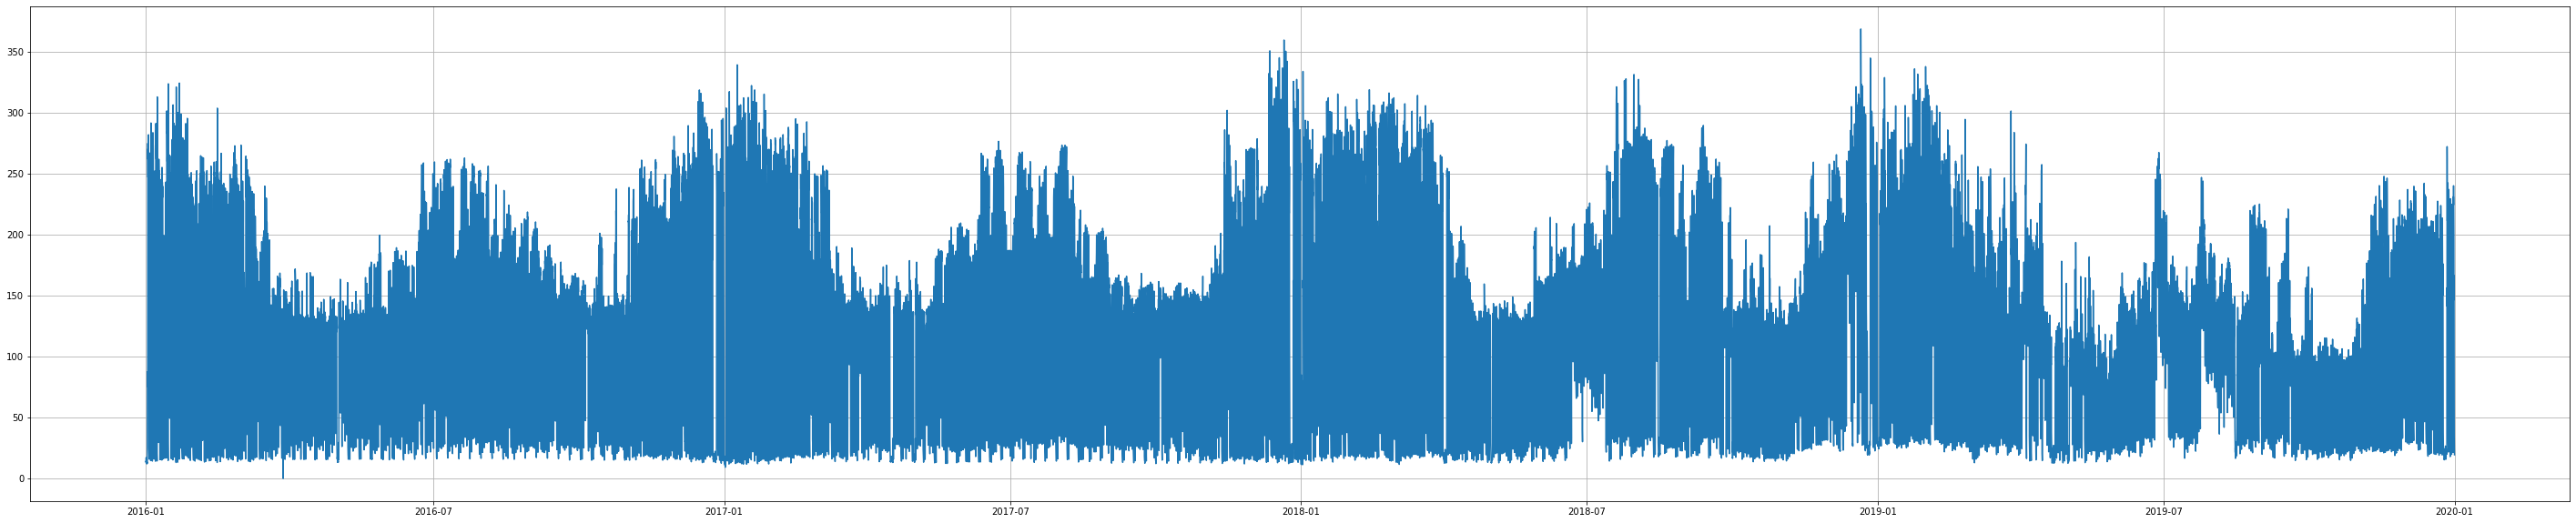

In [8]:
#The consumes in kWh

plt.plot(datacittà['kWh'])
plt.show()

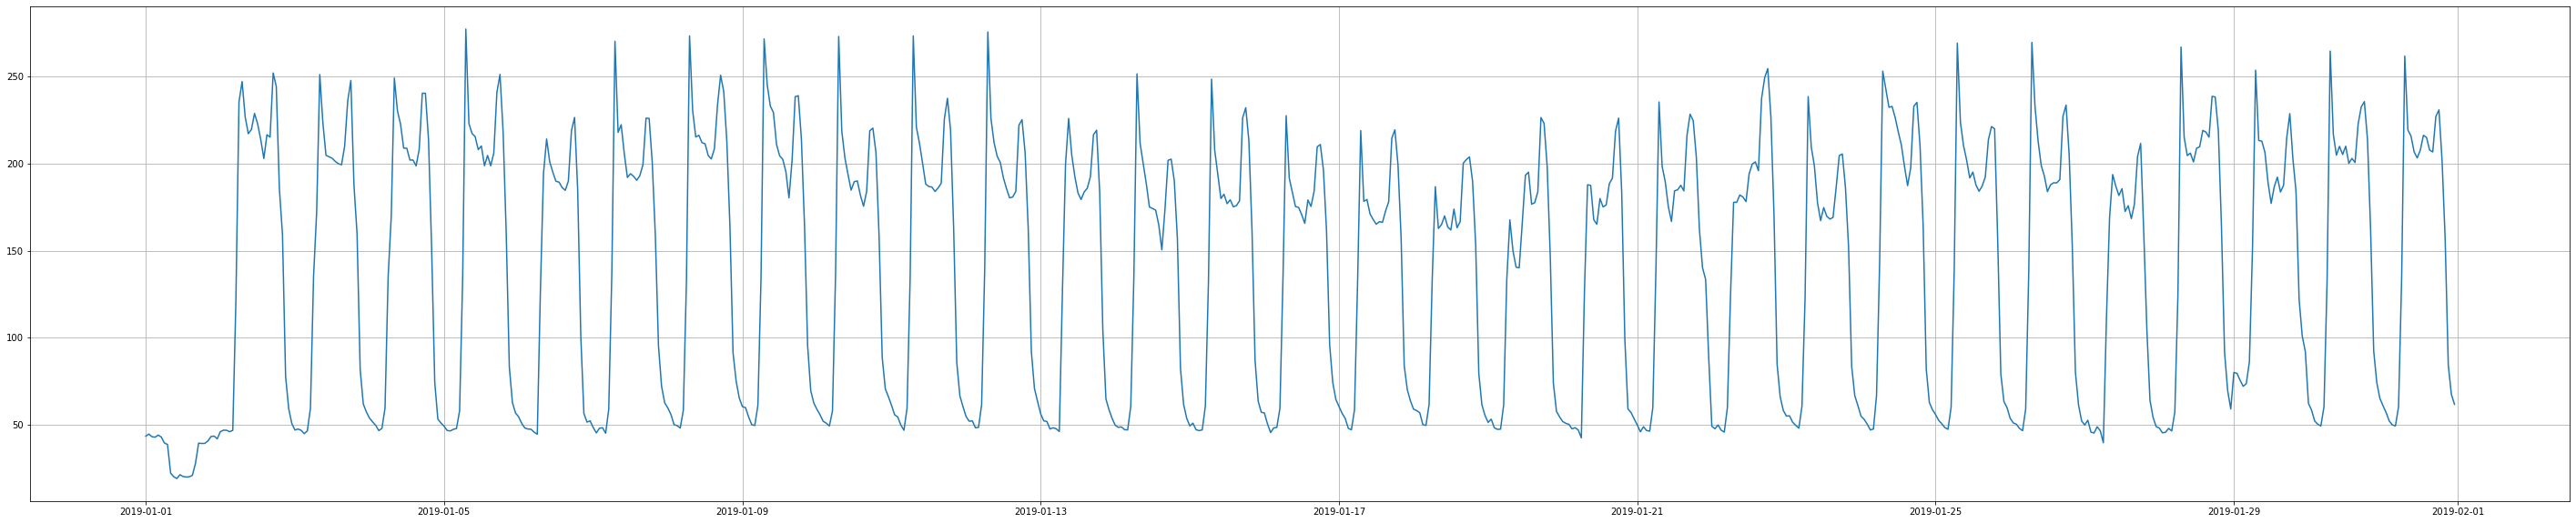

In [32]:
# Zoom on the consumes (example of January 2019)
mask1 = datacittà['year']==2019
mask2 = datacittà['month']==1
plt.plot(datacittà[(mask1) & (mask2)]['kWh'])
plt.show()

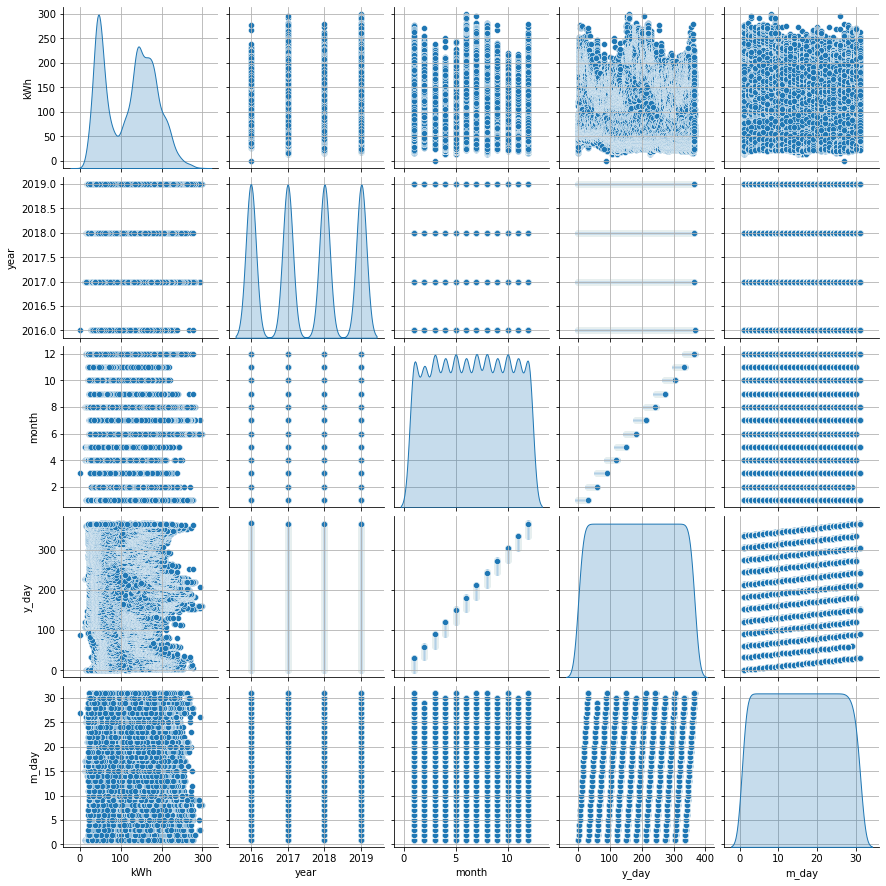

In [33]:
# scatterplot for the consumes and the datetime variables

sns.pairplot(datacittà[['kWh', 'year', 'month', 'y_day', 'm_day']], diag_kind="kde")

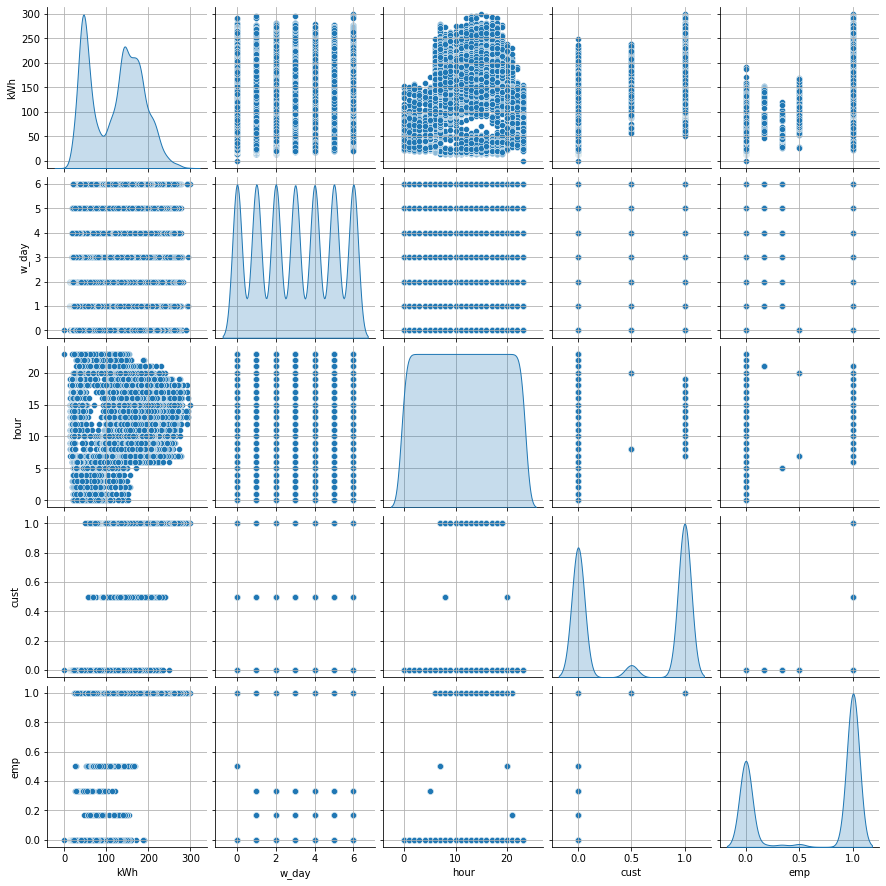

In [34]:
# scatterplot for the consumes, other datetime variables and the presence of customers and emplyees

sns.pairplot(datacittà[['kWh', 'w_day', 'hour', 'cust', 'emp']], diag_kind="kde")

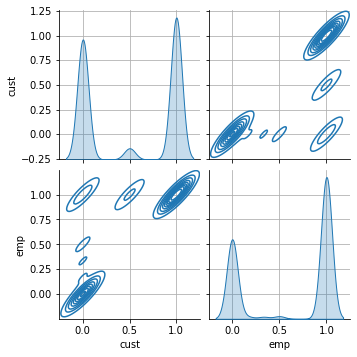

In [77]:
# Saving the picture of the scatter plot of cust and emp for the thesis

sns.pairplot(datacittà[['cust', 'emp']], kind="kde")
plt.savefig('cust_dip.png')

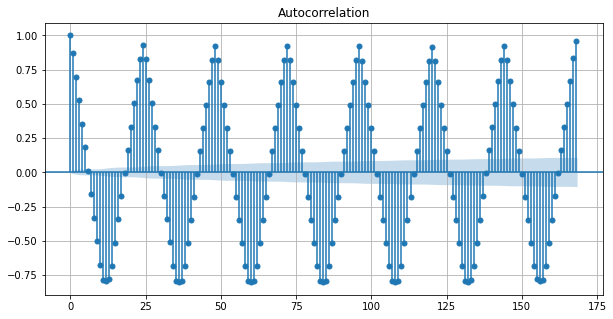

In [38]:
# Saving a picture of the ACF of cust

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(data_edit[città]['cust'].dropna(), ax = ax, lags=24*7)
fig.savefig('cust_acf.png')
plt.show()

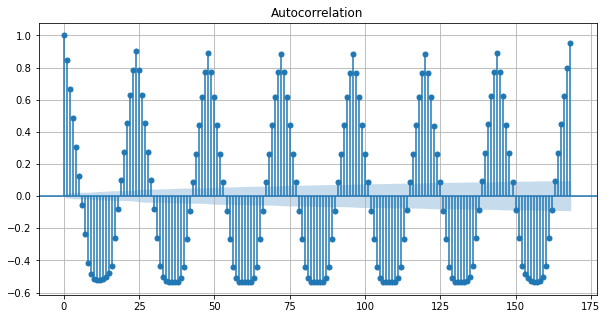

In [39]:
# Saving a picture of the ACF of emp

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(data_edit[città]['emp'].dropna(), ax = ax, lags=24*7)
fig.savefig('emp_acf.png')
plt.show()

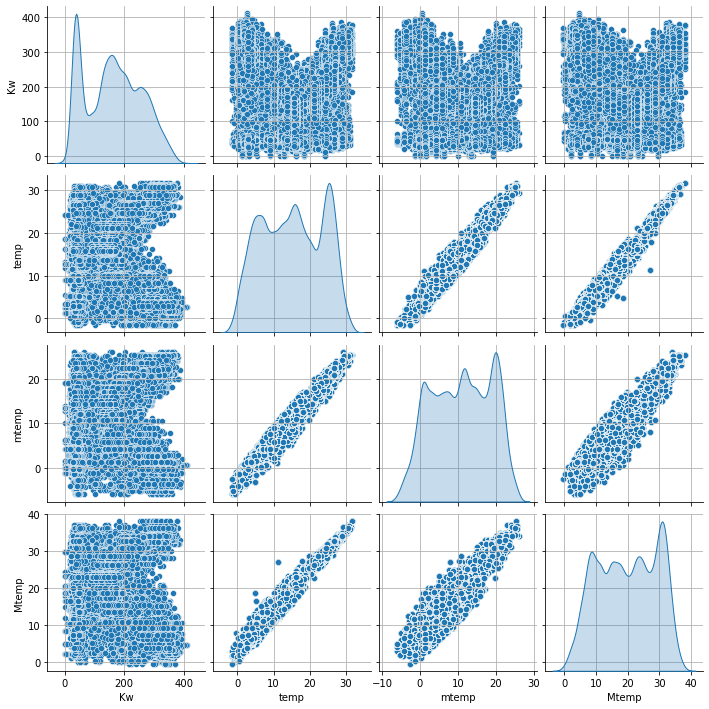

In [12]:
# Scatter plot for the consumes and the temperatures data

sns.pairplot(datacittà[['kWh', 'temp', 'm_temp', 'M_temp']], diag_kind="kde")

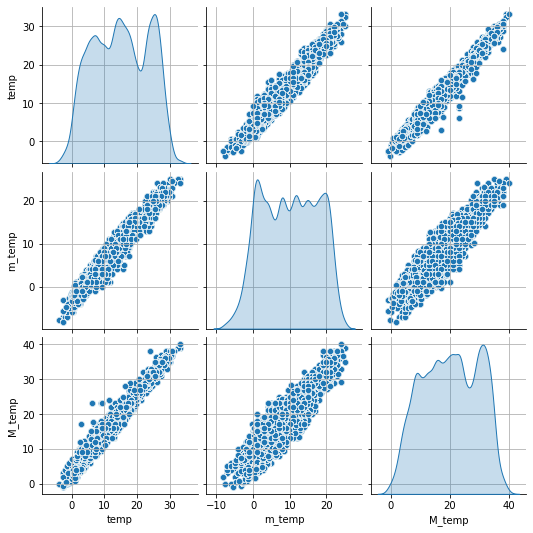

In [40]:
# Saving a picture of the scatter plot for the temperatures

sns.pairplot(datacittà[['temp', 'm_temp', 'M_temp']], diag_kind="kde")
plt.savefig('temps.png')

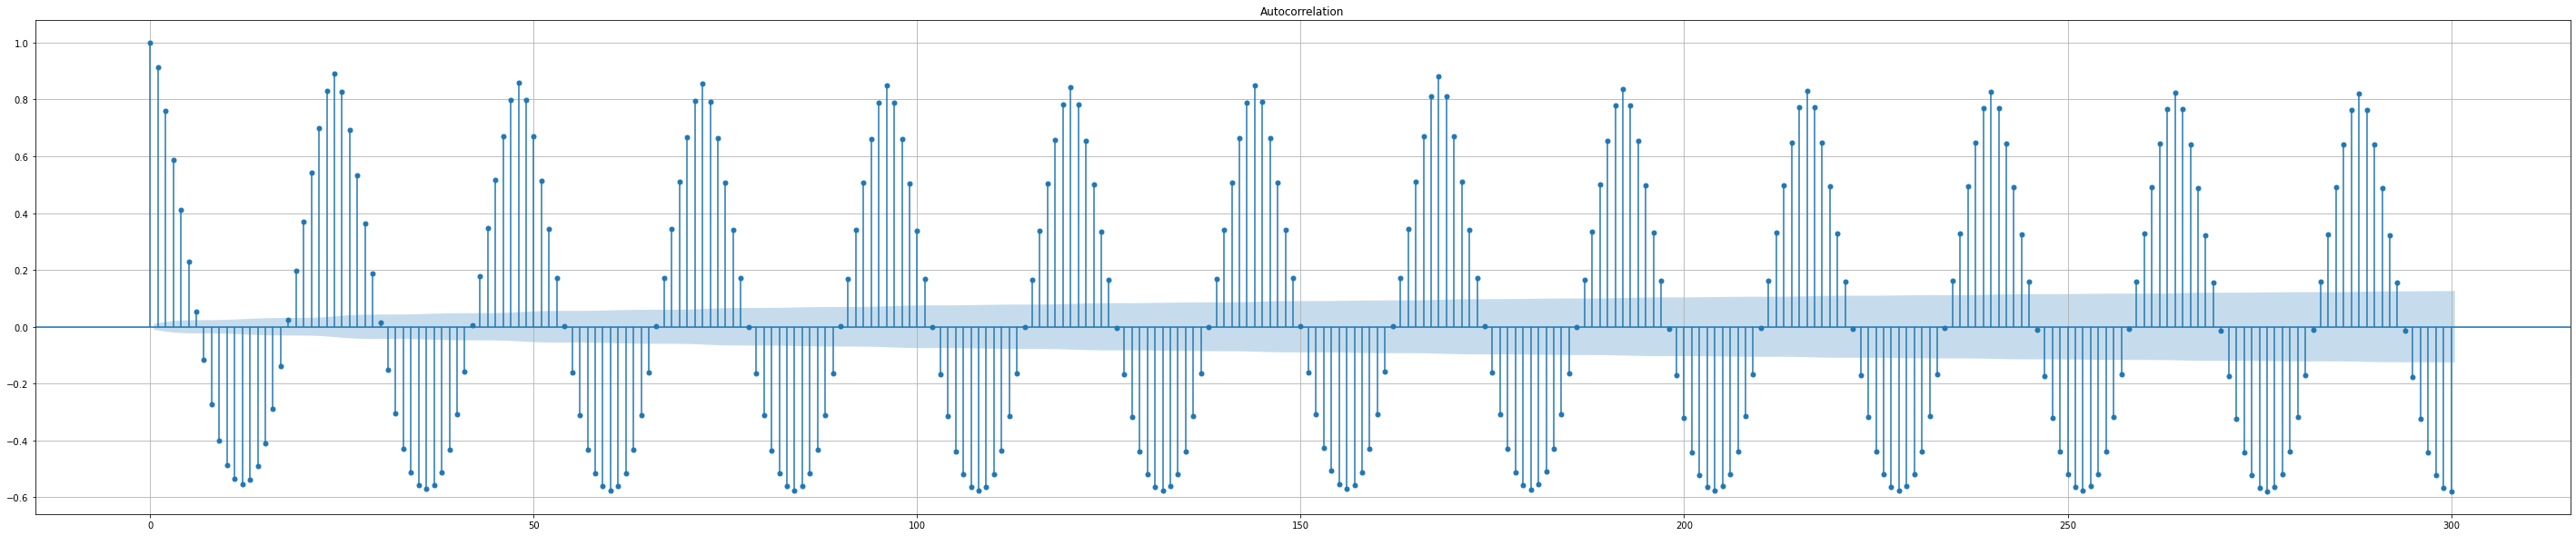

In [41]:
# ACF of the consumes

sm.graphics.tsa.plot_acf(datacittà['kWh'].dropna(), lags=300)
plt.show()

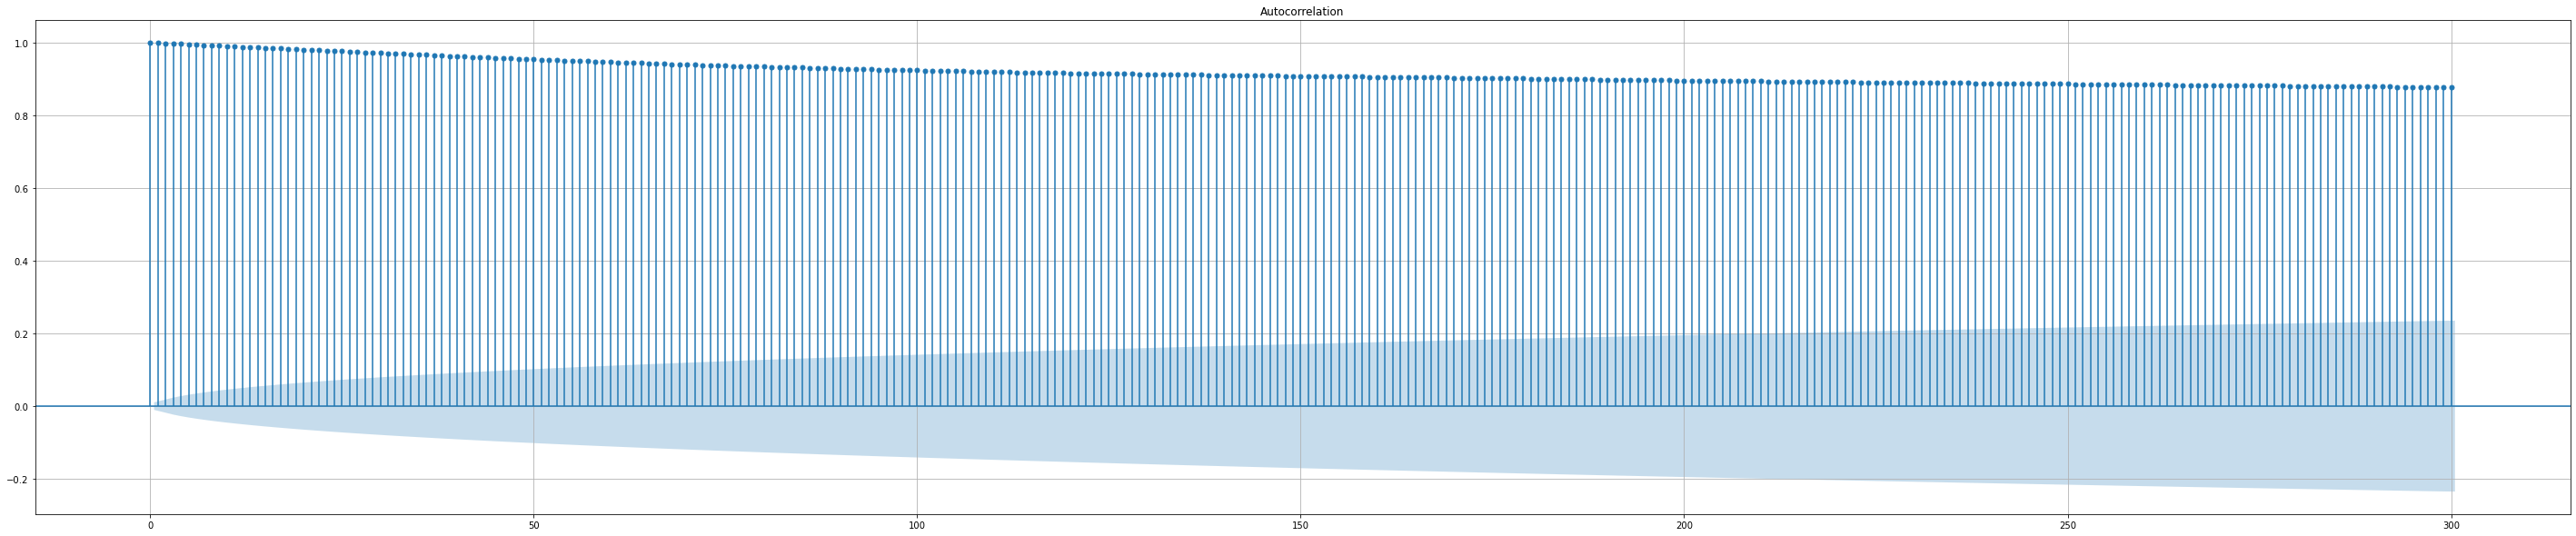

In [19]:
# ACF of temp

sm.graphics.tsa.plot_acf(datacittà['temp'].dropna(), lags=300)
plt.show()

# Studying the effect of temp on the consumes

In [9]:
# here I collect all the temperatures registerd for the store (without duplicates)
temp_list = np.sort(datacittà.dropna()['temp'].unique())

# here I collect the maximum of the consumes for each temperature (remember that the temperature stays the same for each whole day)
cons_list = []
for temp in np.sort(temp_list):
    cons = np.nanmax(datacittà[datacittà['temp'] == temp]['kWh'])
    cons_list.append(cons)

Il minimo dei consumi massimi per ogni temperatura osservata è 106.723 kW.
A tale valore corrisponde la temperatura di 10.4 gradi.


Utilizzando il filtro Savitzky-Golay*, otteniamo che il valore minimo per la temperaura (e scelto come t0) è 16.3 gradi.
A tale temperatura corrisponde il consumo di 160.90800000000002 kW

*https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
https://it.qaz.wiki/wiki/Savitzky%E2%80%93Golay_filter
 Adatta un polinomio di grado  n (n=1 nel nostro caso), ad un sottinsieme dei punti e procede per finestre consucutive.


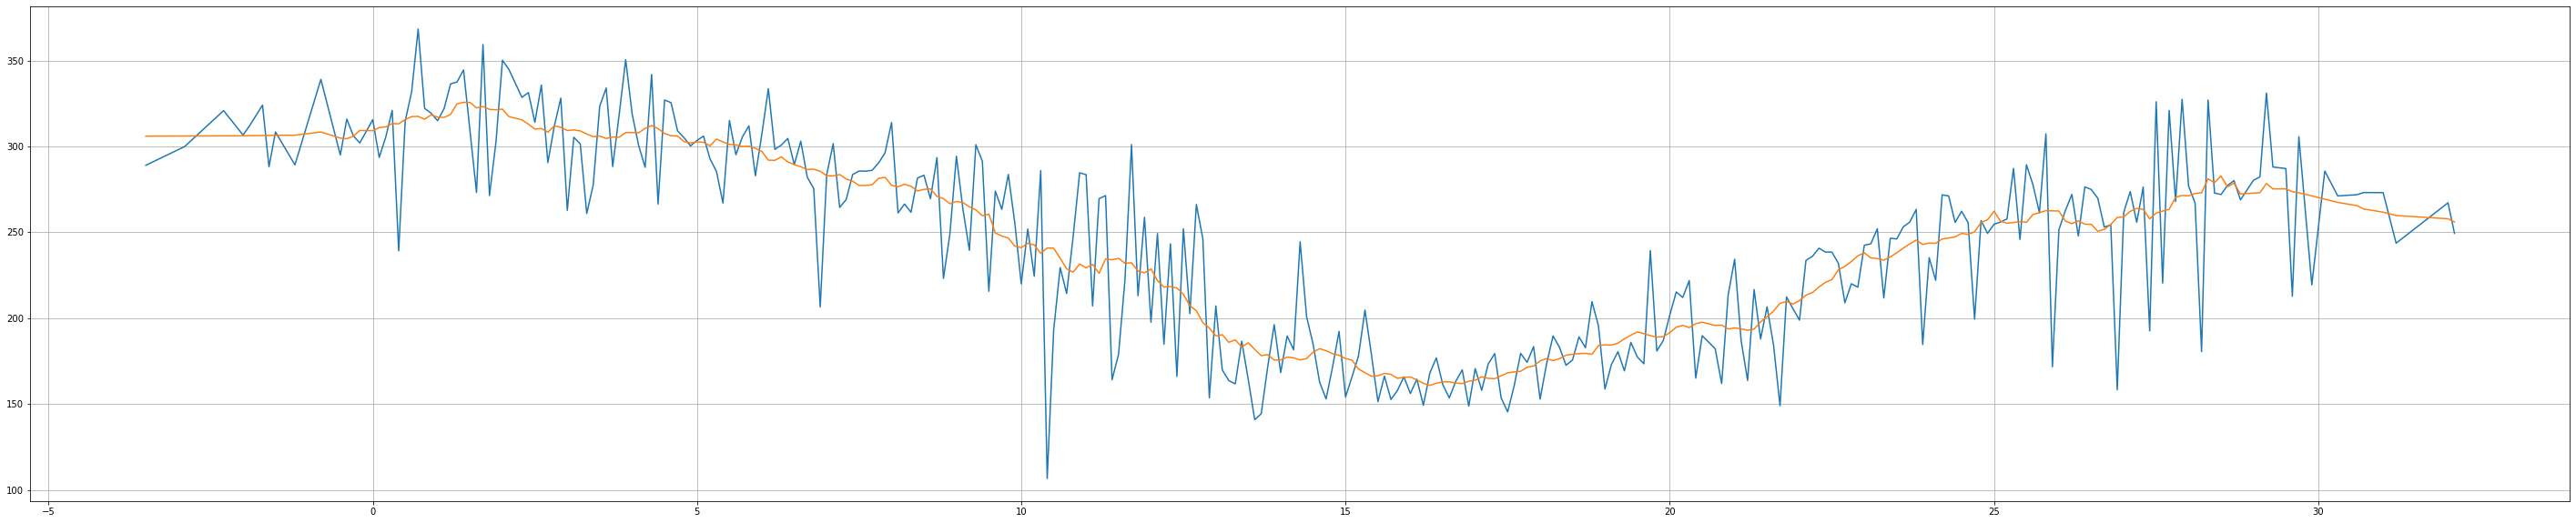

In [10]:
# here we build a ball of influencial observation for the Savitzky-Golay filter (SG filter)
ball = np.round(int(np.sqrt(len(cons_list))))
if ball%2 !=1:
    ball = ball+1
ball = int(ball)

# here we apply the SG filter on the maximum consumes collected above, with the "ball" just built and with a polynomial of degree 1
poly_y = scipy.signal.savgol_filter(cons_list, ball, 1)

# Save the values for t0 and c0 as defined in the thesis
t0 = np.sort(datacittà['temp'].unique())[np.argmin(poly_y)]
c0 = min(poly_y)

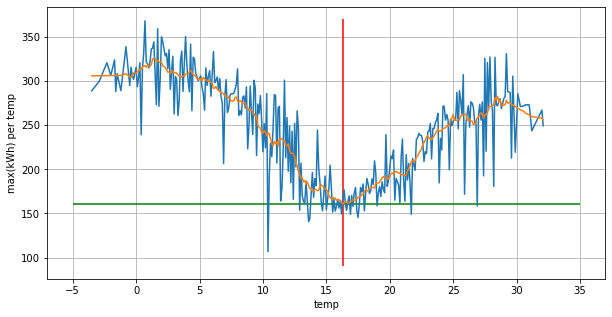

In [12]:
# Saving and plotting the results of the SG filter
# in blu there are the maximum consumes per temperature
# in orange the filtered consumes
# in red t0
# in green c0

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(temp_list, cons_list)
ax.plot(temp_list, poly_y)

ax.vlines(t0, 90,370, colors='red')
ax.hlines(c0, -5, 35, colors='green')
plt.xlabel('temp')
plt.ylabel('max(kWh) per temp')
fig.savefig('SG_filter.png')
plt.show()

# Adding temp+ and temp-
according to the definition given in the thesis.
Temp is split in the 2 new variables and then we subtracted t0 and set =0 the negative values, like in a ReLU.
We also eliminate the effect of the temperature on observations with consumes lower than c0.

In [13]:
# Creating the 2 new variables with center in t0
datacittà['temp+'] = datacittà['temp']-t0
datacittà['temp-'] = t0 - datacittà['temp']

# creating the mask for the observations with temp+/- to be set =0
maskt0p = datacittà['temp+']<0
maskt0n = datacittà['temp-']<0
maskc0 = datacittà['kWh']<c0

# setting the =0s
datacittà.loc[maskt0p, 'temp+']=0
datacittà.loc[maskt0n, 'temp-']=0
datacittà.loc[maskc0, 'temp+']=0
datacittà.loc[maskc0, 'temp-']=0

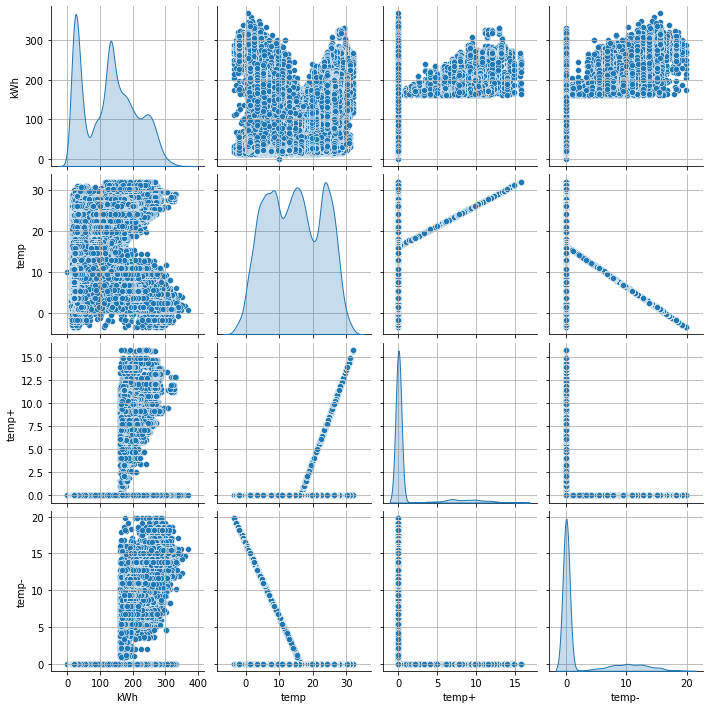

In [15]:
# Saving the scatter plot for the consumes, temp, temp+ and temp-

sns.pairplot(datacittà[['kWh', 'temp', 'temp+', 'temp-']], diag_kind="kde")
plt.savefig('kWh_vs_temps.png')

# Creating temp+ and temp- for all the stores

In [16]:
# same procedure seen above, this time inside a "for cycle" to set the variables for all the stores in the complete dataset
for store in data_edit:
    temp_list = np.sort(data_edit[store].dropna()['temp'].unique())
    cons_list = []
    for temp in np.sort(temp_list):
        cons = np.nanmax(data_edit[store][data_edit[store]['temp'] == temp]['kWh'])
        cons_list.append(cons)
        
    ball = np.round(int(np.sqrt(len(cons_list))))
    if ball%2 !=1:
        ball = ball+1
    ball = int(ball)
    poly_y = scipy.signal.savgol_filter(cons_list, ball, 1)

    t0 = np.sort(data_edit[store]['temp'].unique())[np.argmin(poly_y)]
    c0 = min(poly_y)
    
    data_edit[store]['temp+'] = data_edit[store]['temp']-t0
    data_edit[store]['temp-'] = t0 - data_edit[store]['temp']

    maskt0p = data_edit[store]['temp+']<0
    maskt0n = data_edit[store]['temp-']<0
    maskc0 = data_edit[store]['kWh']<c0

    data_edit[store].loc[maskt0p, 'temp+']=0
    data_edit[store].loc[maskt0n, 'temp-']=0
    data_edit[store].loc[maskc0, 'temp+']=0
    data_edit[store].loc[maskc0, 'temp-']=0

# Chapter 2
# Models for explorative analysis
Here we see the code for creating the models presented in this chapter

# OLS

Model for the store selected at the beginning 

In [112]:
# setting the variables we want as X to build our model on them
X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']

# removing the variables from X that remains constant in the whole store dataset since they don't bring information
X1 = []
for x in X:
    if len(datacittà[x].unique()) > 1:
        X1.append(x)

['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'BMS']


store_3 
                             OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                 3.387e+04
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:20:48   Log-Likelihood:            -1.6773e+05
No. Observations:               35061   AIC:                         3.355e+05
Df Residuals:                   35053   BIC:                         3.356e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.1830      0.295    143.12

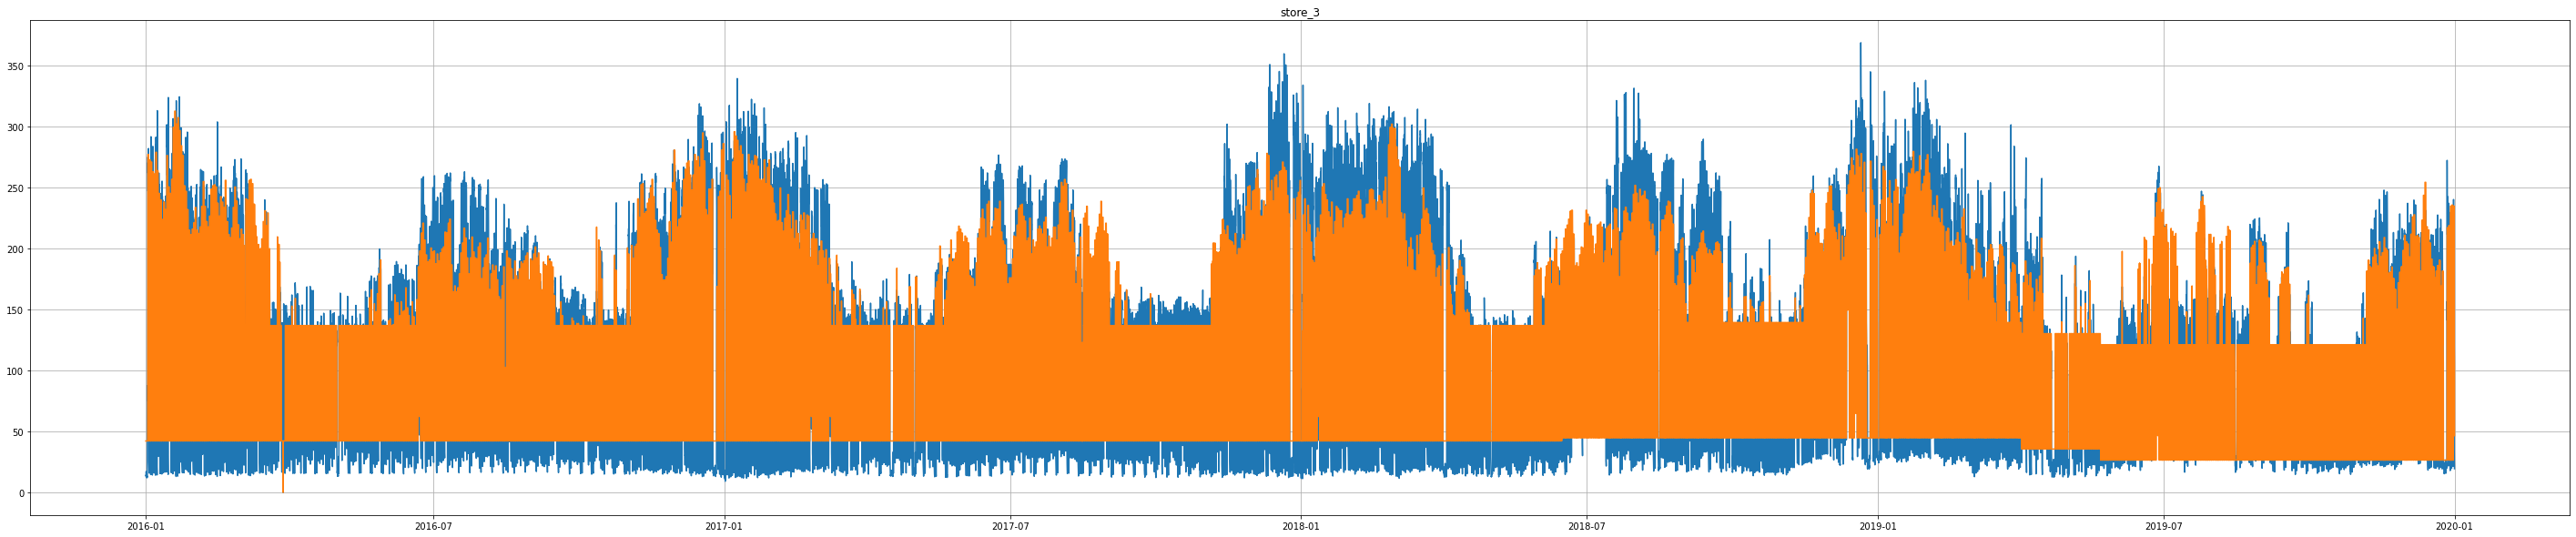

In [113]:
# create x and y on which to build the model
# y is kept as the original observations in kWh
x = datacittà[X1]
y = datacittà['kWh']

# adding the intercept to x
x = sm.add_constant(x)

# building the model thanks to the OLS function in statsmodels
model = sm.OLS(y,x)
results = model.fit()

# print the summary
print(città, '\n', results.summary(), '\n\n')

# defining the fitted values for y
yhat = results.fittedvalues

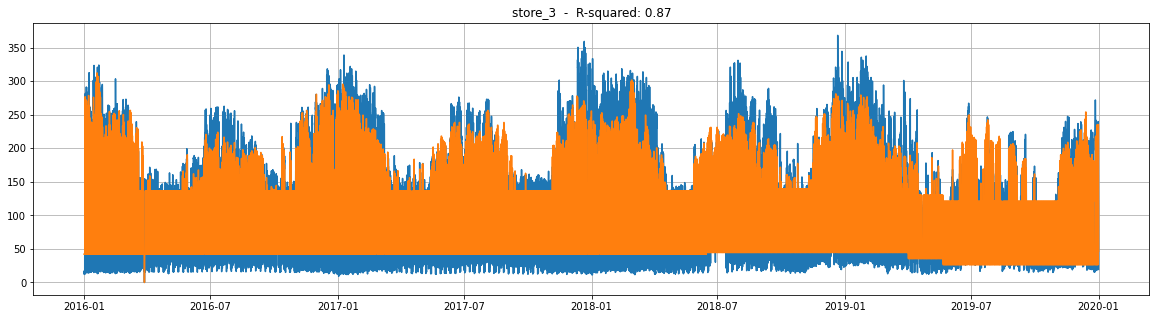

In [141]:
# Saving the picture of y and yhat

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(yhat)
plt.title('{}  -  R-squared: {}'.format(città, np.round(results.rsquared,2)))
fig.savefig('OLS_plot.png')
plt.show()

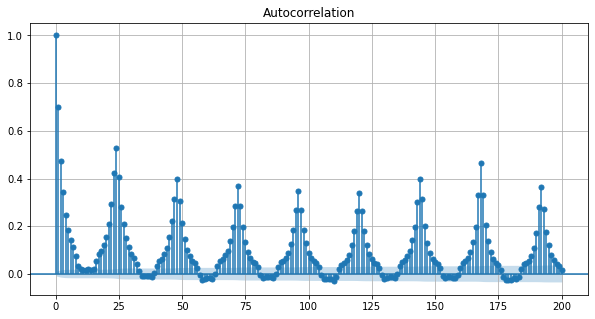

In [115]:
# Saving the ACF of the residuals of the model

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('OLS_acf.png')
plt.show()

Models for all the stores

In [71]:
# saving some metrics to evaluate the models
R2 = []
mse = []
expl_var = []

# same process as above, this time for all the models
for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    x = data_edit[store].dropna()[X1]
    y = data_edit[store].dropna()['kWh']

    x = sm.add_constant(x)

    model = sm.OLS(y,x)
    results = model.fit()
    
    
    # saving the values for the metrics
    R2.append(results.rsquared)
    mse.append(mean_squared_error(y, results.fittedvalues))
    expl_var.append(explained_variance_score(y, results.fittedvalues))

# printing the median for the metrics
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8401949041336612 886.6229211431717 0.8401949041336613


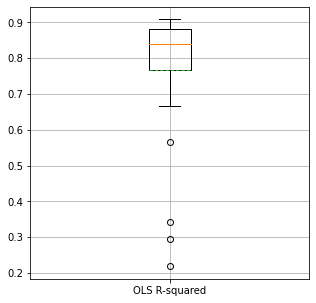

In [161]:
# Saving a boxplot of the R-squared obtained

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.boxplot(R2, labels=['OLS R-squared'], meanline=True, showmeans=True)
fig.savefig('OLS_boxplot.png')
plt.show()

OLS model with transformations of y

store_3 
                             OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 2.429e+04
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:03:03   Log-Likelihood:                -15931.
No. Observations:               35061   AIC:                         3.188e+04
Df Residuals:                   35054   BIC:                         3.194e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5283      0.004    908.85

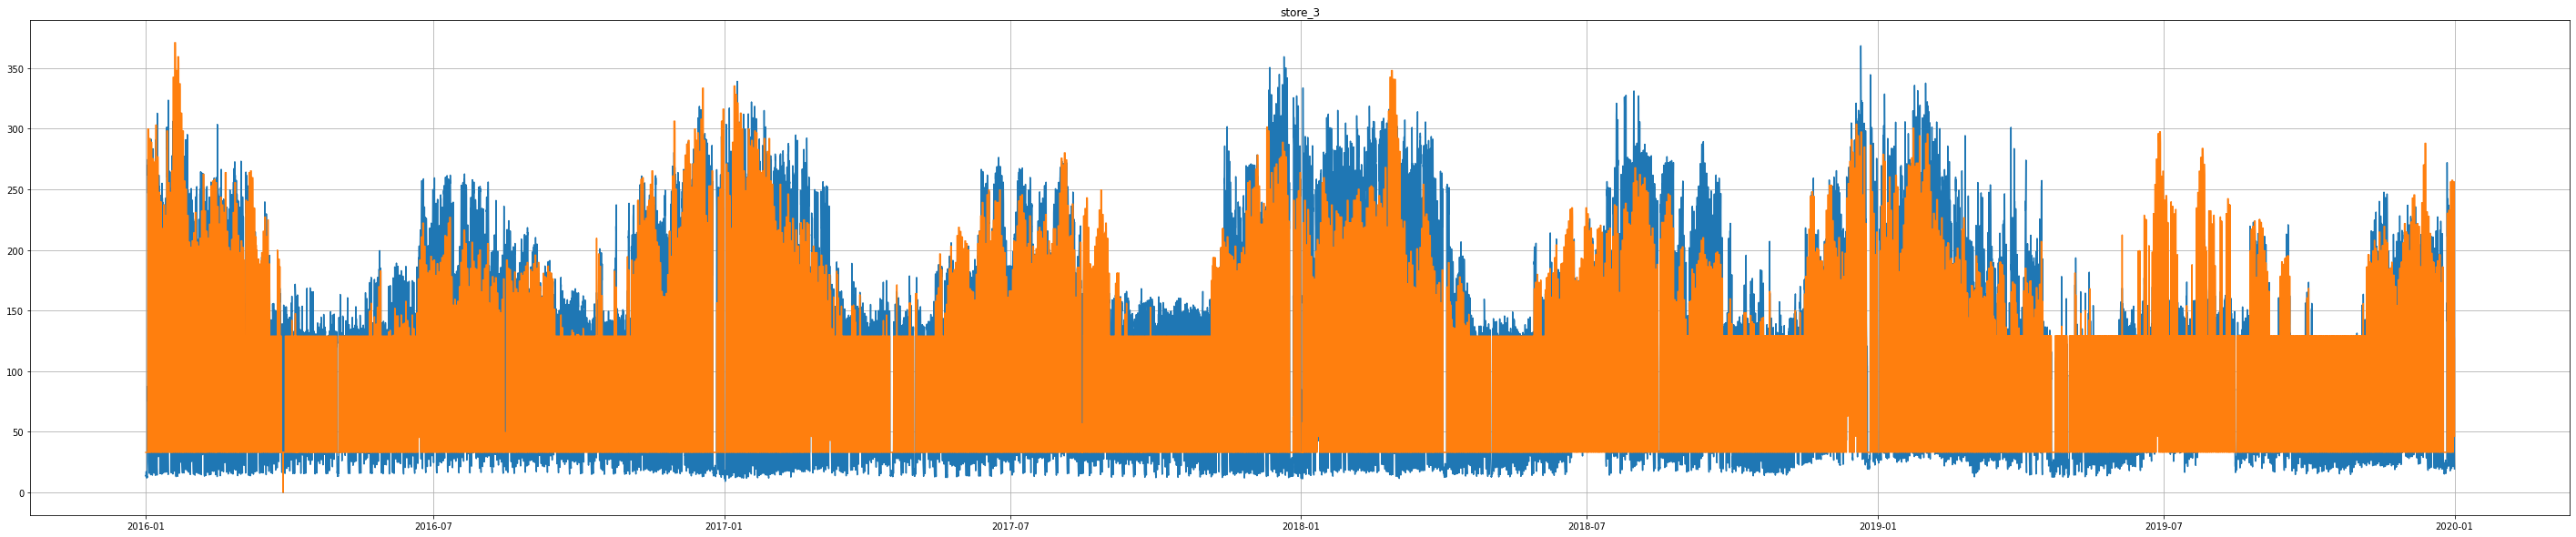

In [155]:
# as above, but this time y = log(1+ kWh)
x = datacittà[X1]
y = np.log(1 + datacittà['kWh'])

x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()
print(città, '\n', results.summary(), '\n\n')

yhat = results.fittedvalues

plt.plot(np.exp(y)-1)
plt.plot(np.exp(yhat)-1)
plt.title('{}'.format(città))
plt.show()

store_3 
                             OLS Regression Results                            
Dep. Variable:                    kWh   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                 2.429e+04
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:03:03   Log-Likelihood:                -15931.
No. Observations:               35061   AIC:                         3.188e+04
Df Residuals:                   35054   BIC:                         3.194e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5283      0.004    908.85

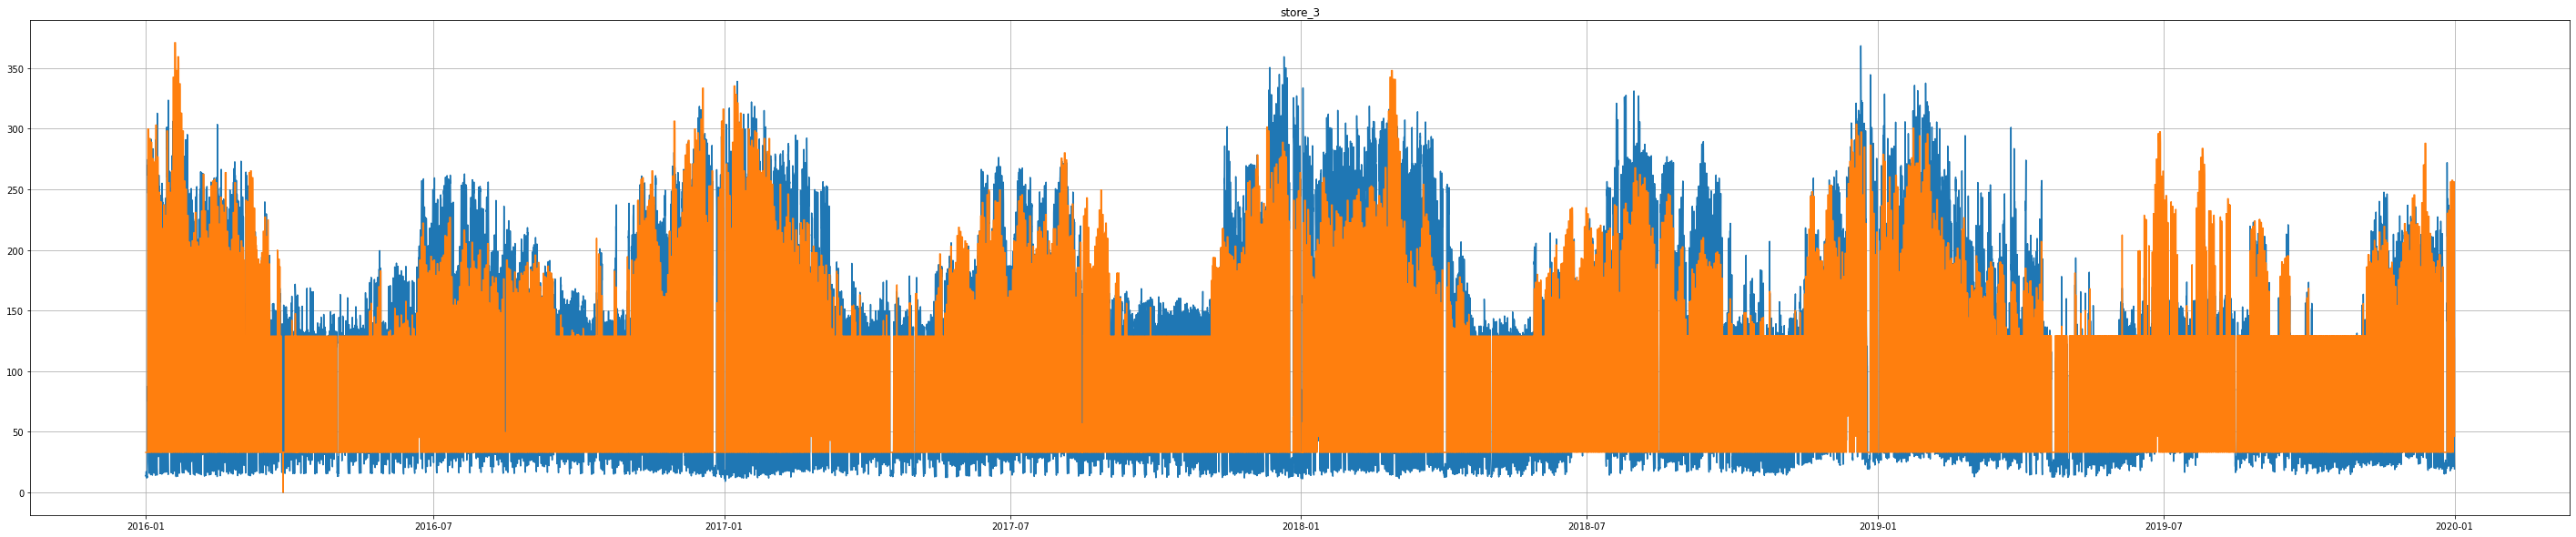

In [155]:
# as above, but this time y = sqrt(kWh)
x = datacittà[X1]
y = np.sqrt(datacittà['kWh'])

x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit()
print(città, '\n', results.summary(), '\n\n')

yhat = results.fittedvalues

plt.plot(y**2)
plt.plot(yhat**2)
plt.title('{}'.format(città))
plt.show()

# NNLS (Non Negative Least Square)

In [72]:
# This time we just show the results for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    x = data_edit[store].dropna()[X1]
    y = data_edit[store].dropna()['kWh']

    x = sm.add_constant(x)
    
    # the model is built thanks to the command nnls in scipy
    coef, res = scipy.optimize.nnls(x, y)
    yhat = x.dot(coef)
    
    R2.append(r2_score(y, yhat))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8385766518467574 904.0848257661919 0.8385766518467573


# Decision Tree

[0.7549494107442539, 0.7583902638827039, 0.7590035270417878, 0.7589592727092284, 0.7582424191187745, 0.7573640814977755, 0.7573025783658736, 0.7562255166210987, 0.7556448726463426]


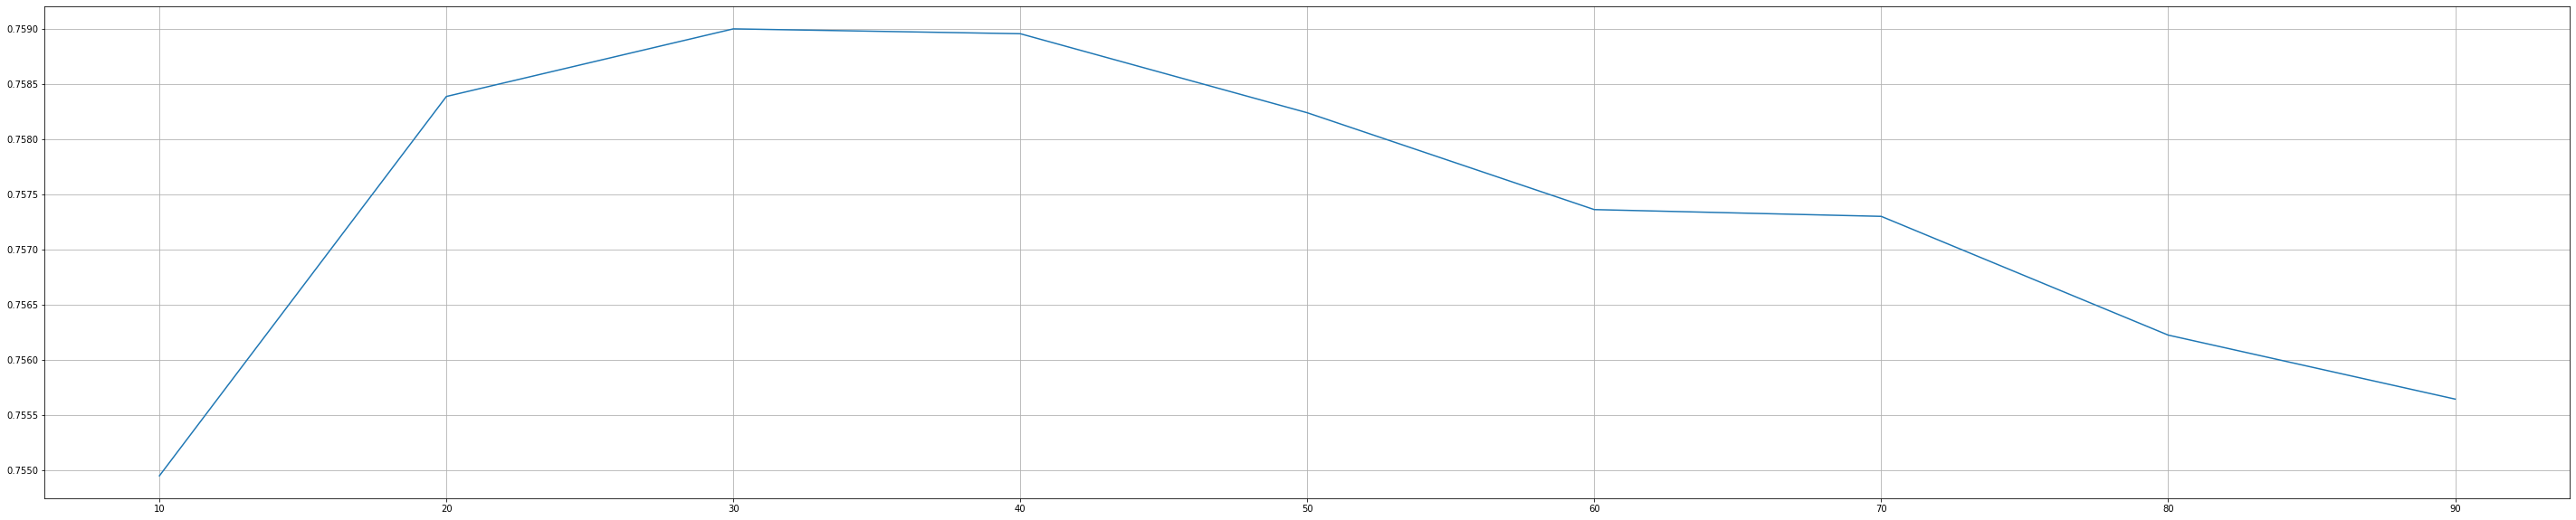

In [14]:
# 5-fold Cross Validation to select the best value for the maximum number of leaves of thr DT

num_leaves = range(10,100,10)
scores = []
for i in num_leaves:
    i_scores = []
    for store in data_edit:
        X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
        X1 = []
        for x in X:
            if len(data_edit[store].dropna()[x].unique()) > 1:
                X1.append(x)
    
        
        x = data_edit[store].dropna()[X1]
        y = data_edit[store].dropna()['kWh']
        
        model = DecisionTreeRegressor(max_leaf_nodes = i)
        città_scores = cross_val_score(model, x, y, scoring='r2', cv=5)
        città_score = np.nanmean(città_scores)
        i_scores.append(città_score)
    i_score = np.nanmean(i_scores)
    scores.append(i_score)
    
mln = num_leaves[np.argmax(scores)]
print(mln)

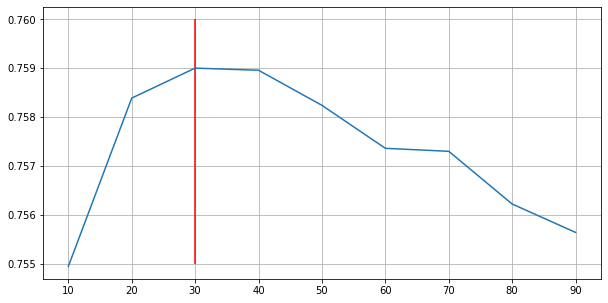

In [15]:
# Saving a picture of the R-squareds scored in the 5-fold CV
# The red line is the maximum value

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.plot(num_leaves, scores)
ax.vlines(mln, 0.755, 0.76, color='red')
fig.savefig('DT_kfCV.png')
plt.show()

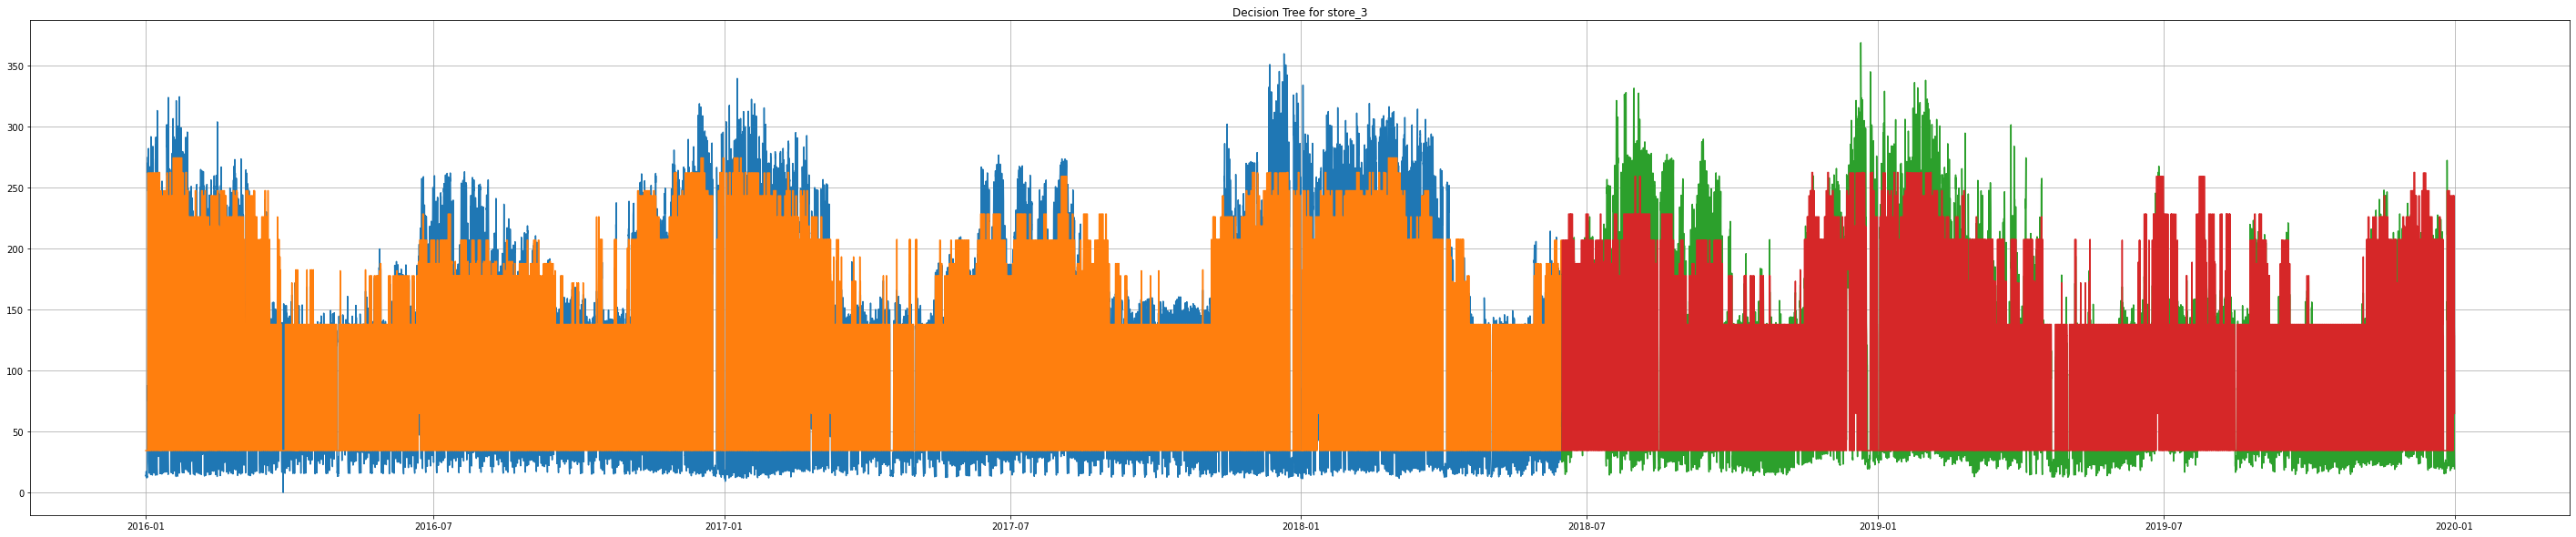

In [22]:
# setting the varaibles in X
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []
for x in X:
    if len(datacittà.dropna()[x].unique()) > 1:
        X1.append(x)

# finding the time of the first intervention to split the dataset in training/test sets
index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

# x, y -> training set
# x1,y1 -> test set
x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh']
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# building the model thanks to the command in sklearn
model = DecisionTreeRegressor(max_leaf_nodes = mln) 
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

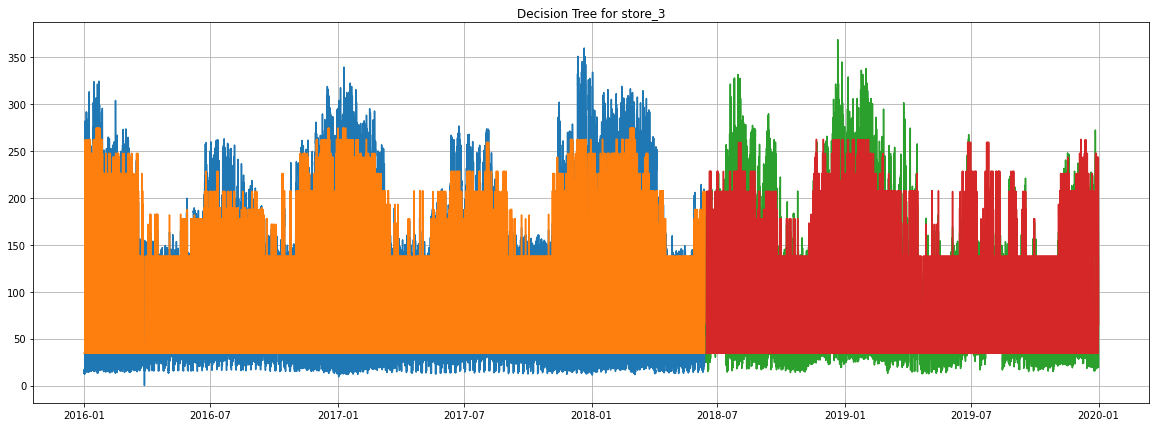

In [23]:
# Saving the plot
# in blue the kWh pre first intervention
# in orange the estimated kWh pre first intervention
# in greem the kWh post first intervention
# in red the estimated kWh post first intervention

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(yhat)
ax.plot(y1)
ax.plot(pred)
plt.title('Decision Tree for {}'.format(città))
fig.savefig('DT_plot_ex.png')
plt.show()

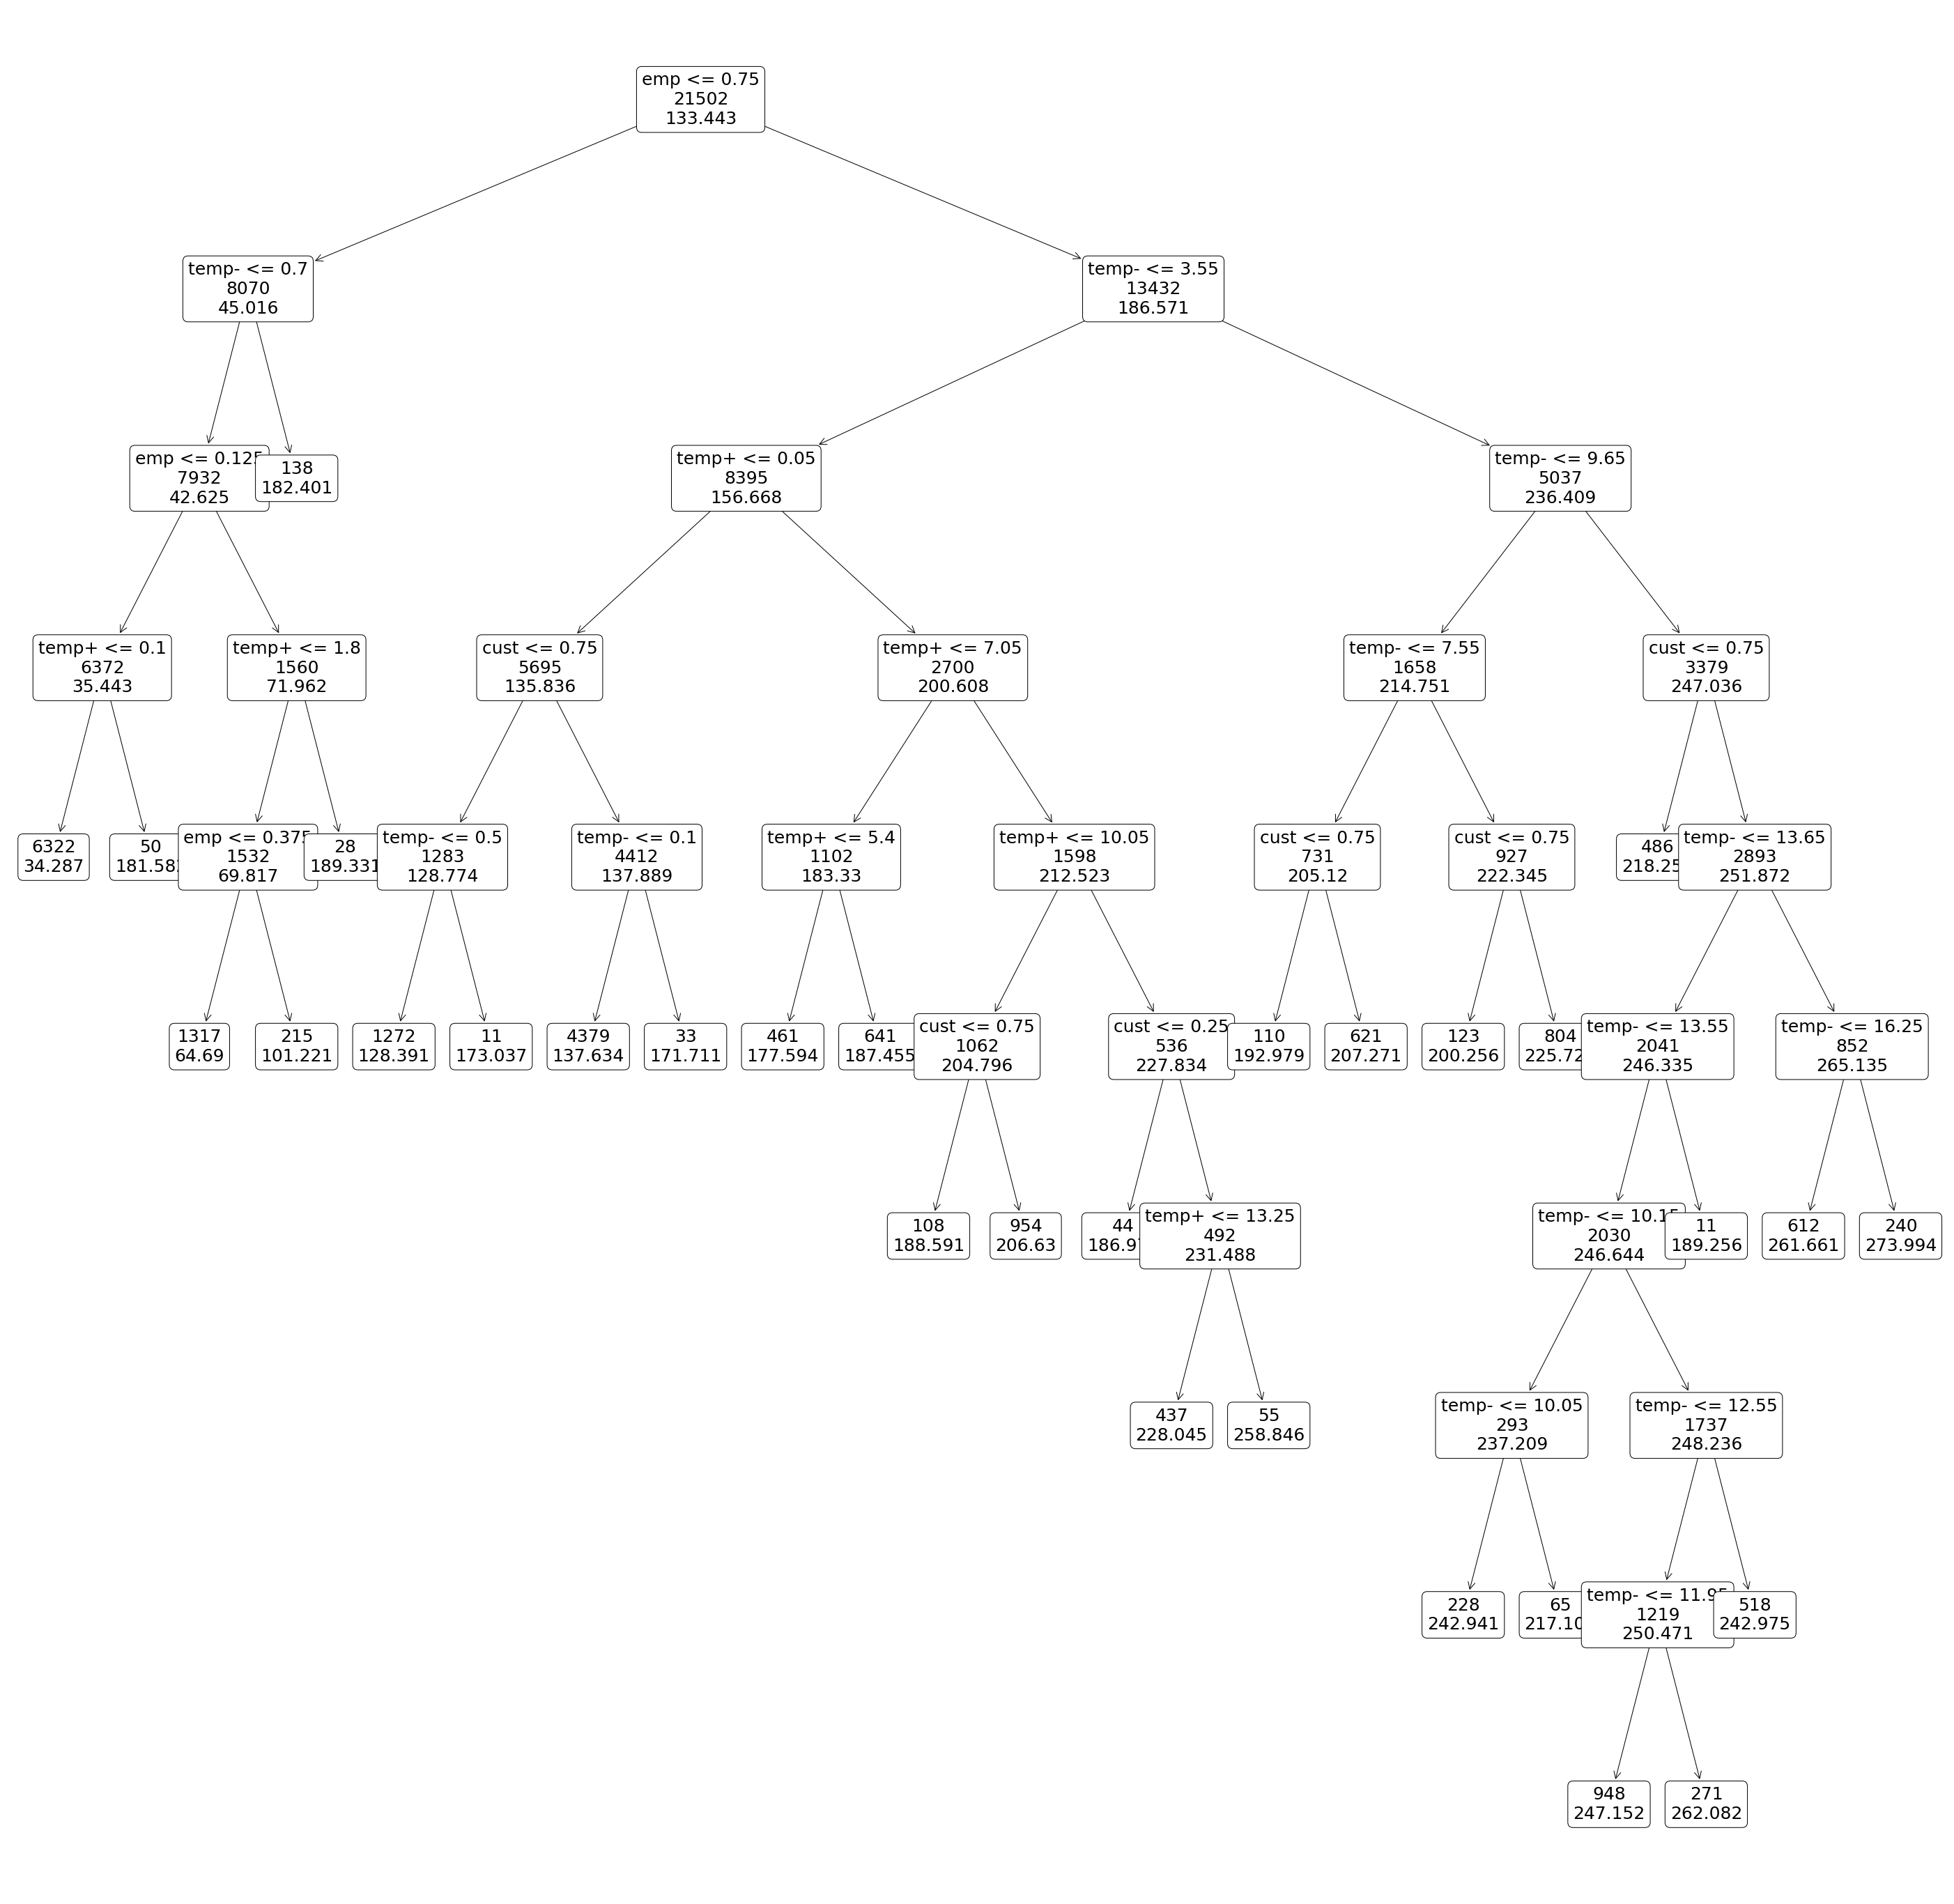

In [196]:
# Saving the tree

fig= plt.figure(figsize=(50,50))
plot_tree(model, feature_names=X, label='none', impurity=False, rounded=True, fontsize=25)
fig.savefig('DT_tree.png')
plt.show()

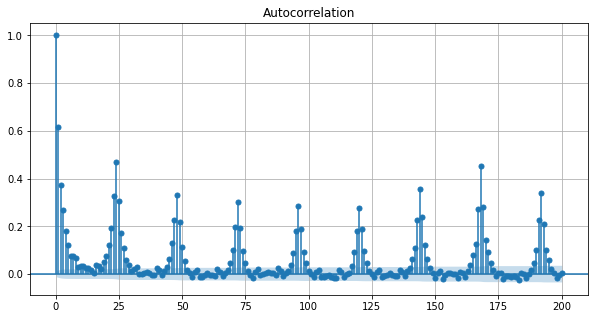

In [192]:
# Saving the ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('DT_acf.png')
plt.show()

In [76]:
# Again for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    # setting X
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    # finding index0
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    # 5-fold CV to select the maximum number of leaves
    max_leaf_nodes = range(20,51,5)
    parameters = {'max_leaf_nodes':max_leaf_nodes}
    clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=-1)
    clf.fit(X=x, y=y)
    
    # building the model
    model = DecisionTreeRegressor(max_leaf_nodes = clf.best_params_['max_leaf_nodes'])
    results = model.fit(x, y)

    yhat = results.predict(x)
    yhat = pd.Series(yhat, index=x.index)
    
    #evaluating the results on the training set
    R2.append(results.score(x,y))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8806551501017987 776.4165836772339 0.8806551501017987


# Random Forest

{'max_leaf_nodes': 35, 'n_estimators': 11}


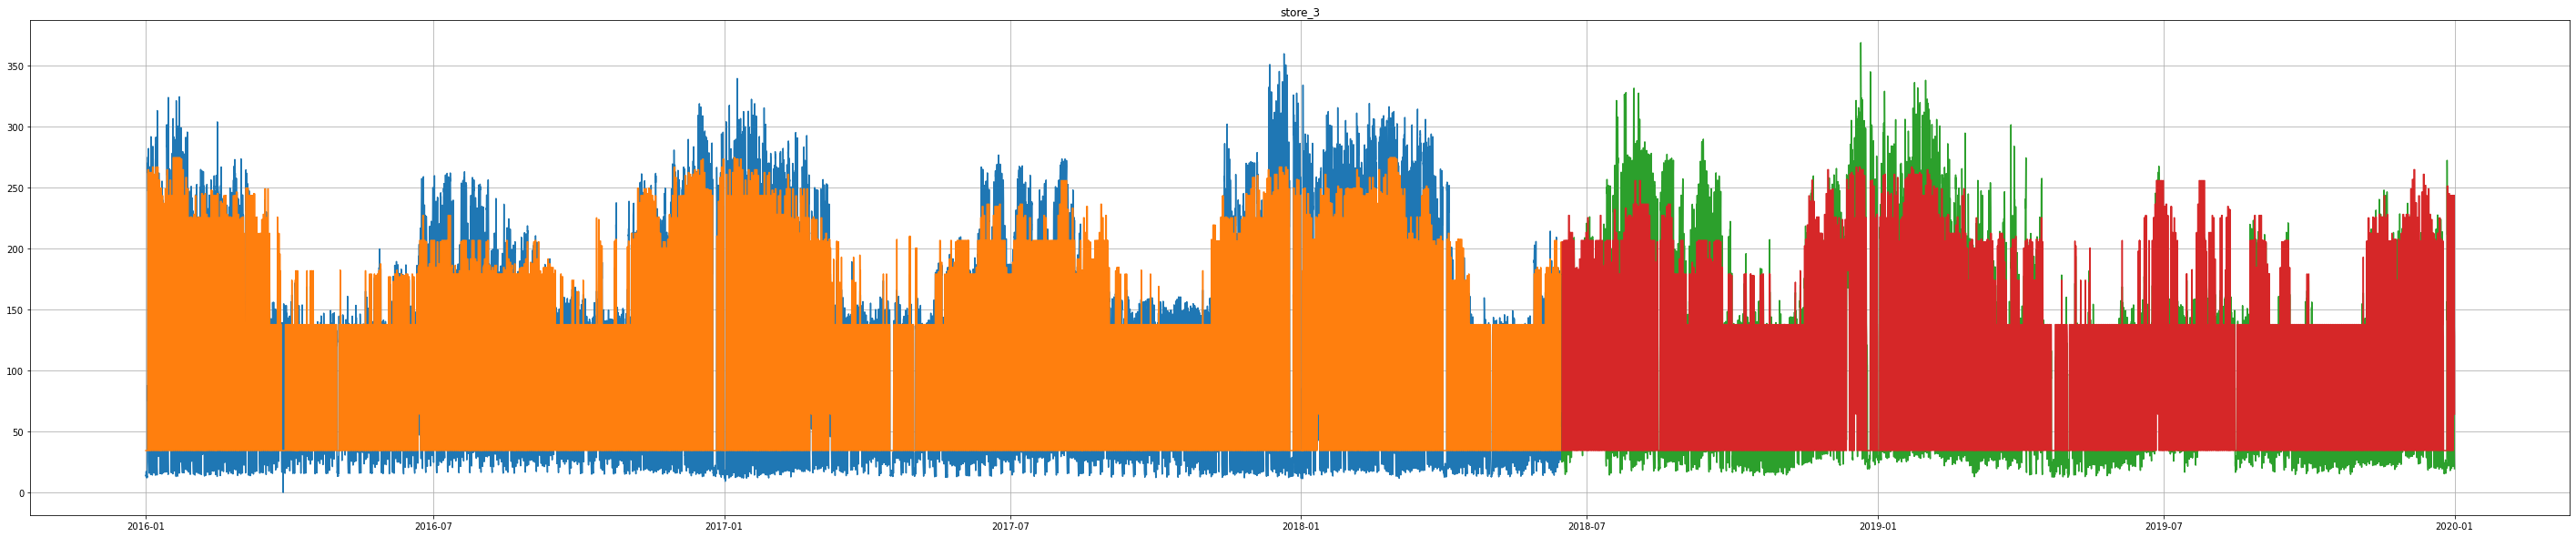

In [39]:
# Setting X
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []
for x in X:
    if len(data_edit[store].dropna()[x].unique()) > 1:
        X1.append(x)

# finding index0
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh']
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# 5-fold CV for the number of trees and the maximum number of leaves in each tree
n_estimators = range(1,52, 5)
max_leaf_nodes = range(20,51,5)
parameters = {'n_estimators':n_estimators, 'max_leaf_nodes':max_leaf_nodes}
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
clf.fit(X=x, y=y)
print(clf.best_params_)

# building the model thanks to the command again in sklearn
model = RandomForestRegressor(n_estimators = clf.best_params_['n_estimators'], max_leaf_nodes = clf.best_params_['max_leaf_nodes'])
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)

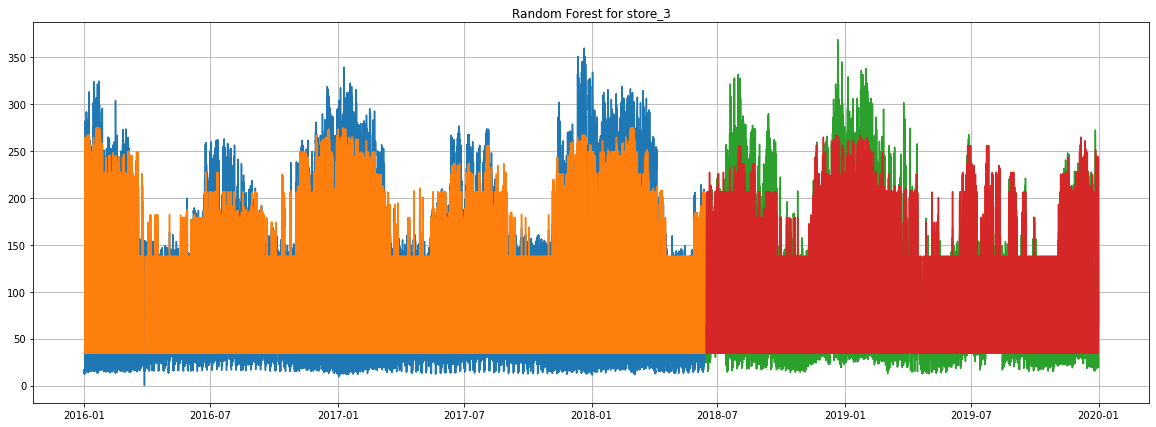

In [40]:
# Saving the plot
# colors as before

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot()
ax.plot(y)
ax.plot(yhat)
ax.plot(y1)
ax.plot(pred)
plt.title('Random Forest for {}'.format(città))
fig.savefig('RF_plot_ex.png')
plt.show()

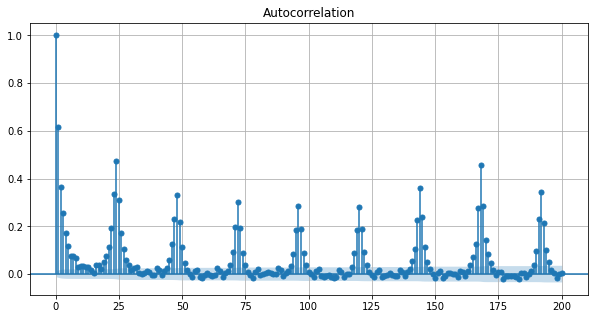

In [41]:
# Saving the ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('RF_acf.png')
plt.show()

In [78]:
# Again for all the stores

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1: #data_edit['store_'].dropna()
            X1.append(x)
    
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    n_estimators = range(1,52, 5)
    max_leaf_nodes = range(20,51,5)
    parameters = {'n_estimators':n_estimators, 'max_leaf_nodes':max_leaf_nodes}
    clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=-1)
    clf.fit(X=x, y=y)

    model = RandomForestRegressor(n_estimators = clf.best_params_['n_estimators'], max_leaf_nodes = clf.best_params_['max_leaf_nodes'])
    results = model.fit(x, y)

    yhat = results.predict(x)
    yhat = pd.Series(yhat, index=x.index)
    
    
    R2.append(results.score(x,y))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8811847338725893 771.5088815639133 0.8811849119727695


# K-Neighbors Regressor

{'n_neighbors': 60, 'weights': 'distance'}


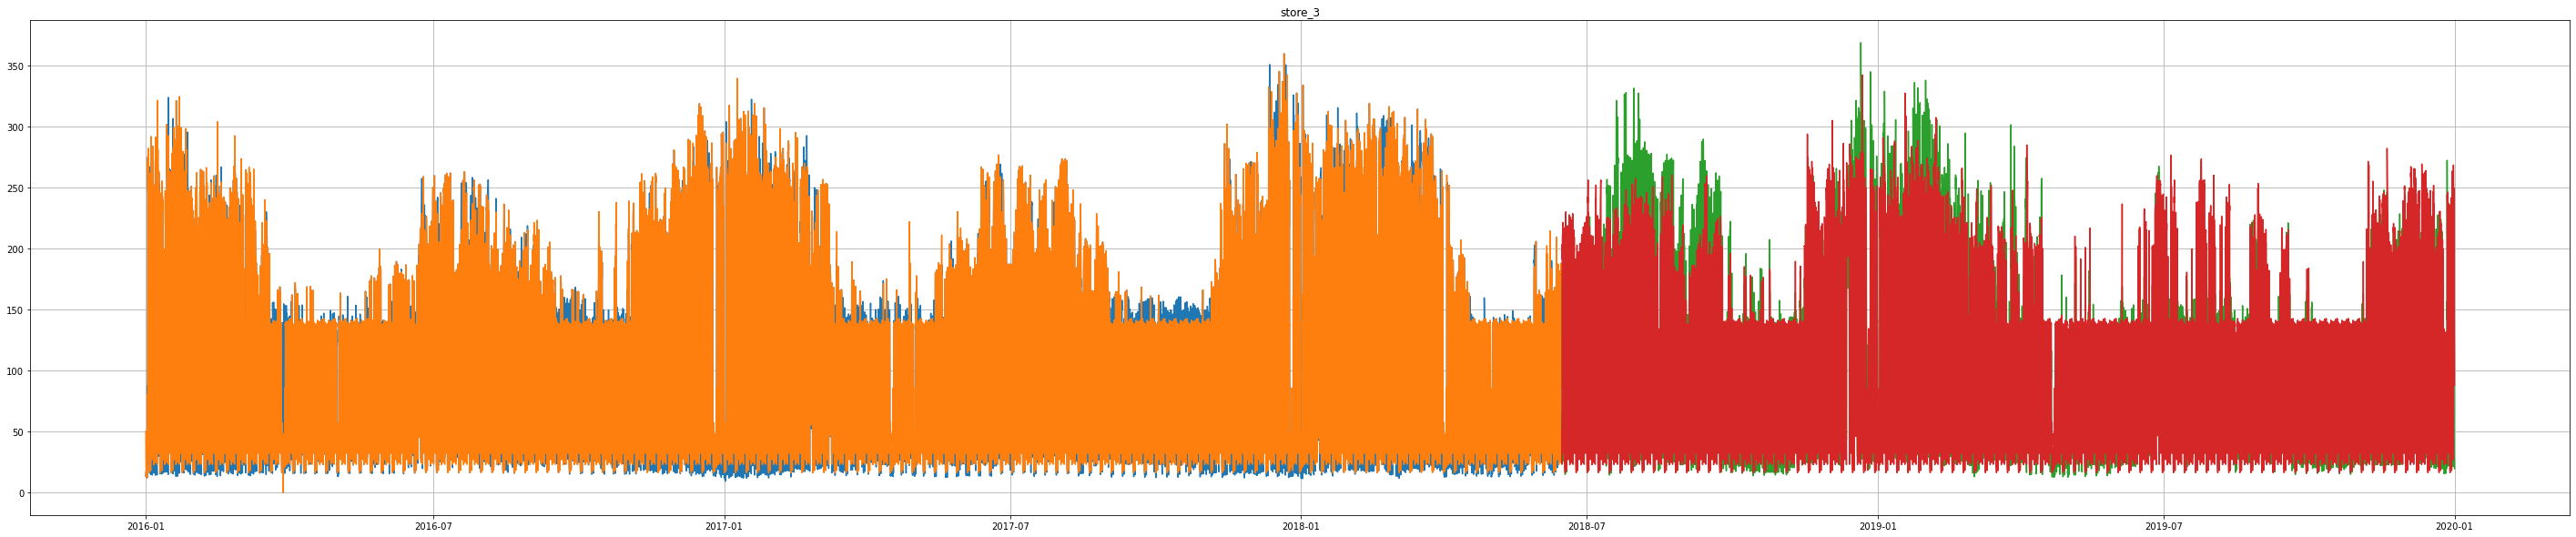

In [63]:
# set X
X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'w_day', 'hour']
X1 = []
for x in X:
    if len(data_edit[store].dropna()[x].unique()) > 1:
        X1.append(x)

# find index0
index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

# set x,x1,y,y1 as defined also before
# here we also add the dummies for w_day and hour
x = datacittà[datacittà.index<index0].dropna()[X1]
x = pd.get_dummies(x, prefix='w_day', columns=['w_day'])
x = pd.get_dummies(x, prefix='hour', columns=['hour'])
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
x1 = pd.get_dummies(x1, prefix='w_day', columns=['w_day'])
x1 = pd.get_dummies(x1, prefix='hour', columns=['hour'])
y = datacittà[datacittà.index<index0].dropna()['kWh']
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']

# 5-fold CV to find the best value k for the closest neighbors to consider
n_neighbors = range(30,101,10)
parameters = {'n_neighbors':n_neighbors, 'weights':['distance']}
clf = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1)
clf.fit(X=x, y=y)

# fitting the kNN model
model = KNeighborsRegressor(clf.best_params_['n_neighbors'], weights = 'distance')
results = model.fit(x, y)

yhat = results.predict(x)
yhat = pd.Series(yhat, index=x.index)
pred = results.predict(x1)
pred = pd.Series(pred, index=x1.index)


# plotting the results
plt.plot(y)
plt.plot(yhat)
plt.plot(y1)
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

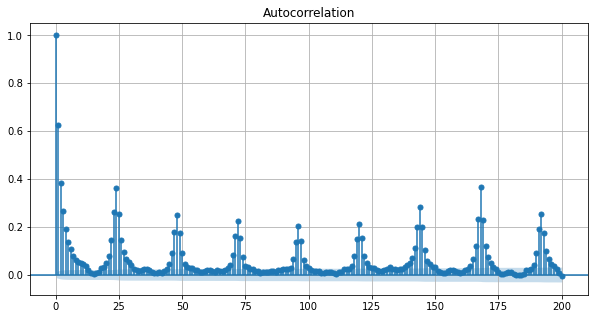

In [65]:
# Saving ACF

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(y-yhat, ax = ax, lags=200)
fig.savefig('kNN_acf.png')
plt.show()

In [79]:
# kNN for all the stores (without dummies)

R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1:
            X1.append(x)
    
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh']
    
    n_neighbors = range(30,101,10)
    parameters = {'n_neighbors':n_neighbors, 'weights':['distance']}
    clf = GridSearchCV(KNeighborsRegressor(), parameters, n_jobs=-1)
    clf.fit(X=x, y=y)

    model = KNeighborsRegressor(clf.best_params_['n_neighbors'], weights = 'distance')
    results = model.fit(x, y)

    yhat = results.predict(x)
    yhat = pd.Series(yhat, index=x.index)
    
    
    R2.append(results.score(x,y))
    mse.append(mean_squared_error(y, yhat))
    expl_var.append(explained_variance_score(y, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.8630576950805949 862.1558901098231 0.8740950482459591


# Autoregressivo
Lag = 1, 2, 24, 7*24

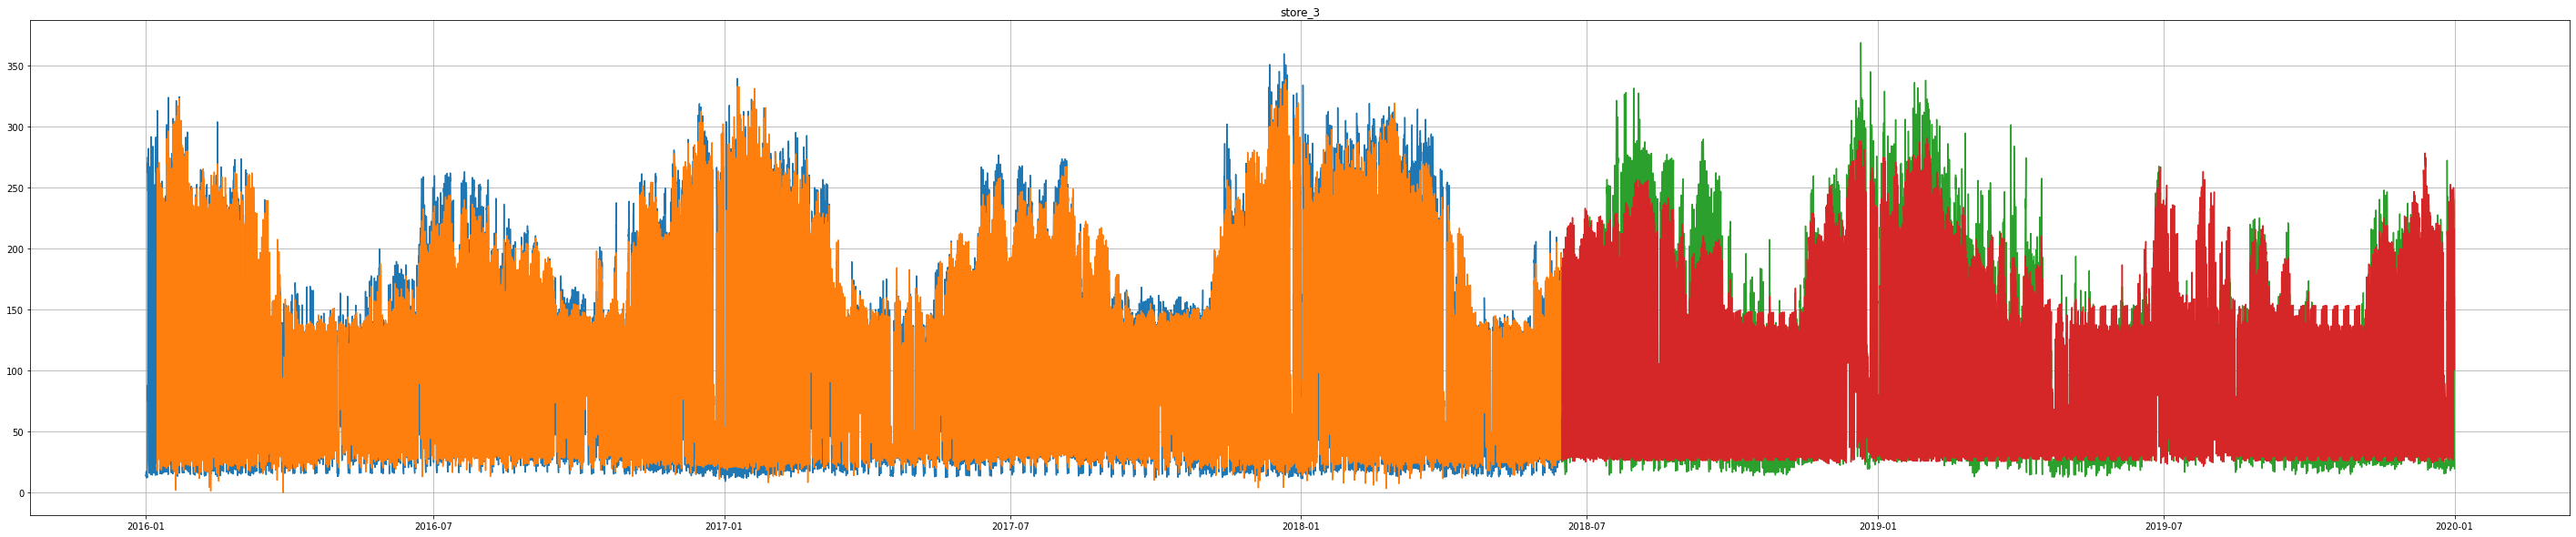

In [98]:
X = ['error', 'cust', 'emp', 'temp+', 'temp-']
X1 = []

for x in X:
    if len(datacittà[x].unique()) > 1:
        X1.append(x)


index0 = datetime.datetime(2020, 1, 1)
for intervention in ['led', 'pvp', 'BMS']:
    if len(datacittà.dropna()[intervention].unique()) > 1:
        if index0 > datacittà[datacittà[intervention]==1].index[0]:
            index0 = datacittà[datacittà[intervention]==1].index[0]

x = datacittà[datacittà.index<index0].dropna()[X1]
x1 = datacittà[datacittà.index>=index0].dropna()[X1]
y = datacittà[datacittà.index<index0].dropna()['kWh'].values
y1 = datacittà[datacittà.index>=index0].dropna()['kWh']



model = AutoReg(y, [1, 2, 24, 7*24], exog=x)
results = model.fit()

y=pd.Series(y)
y.index = x.index
yhat = results.fittedvalues
pred = results.predict(start = len(y), end = len(y)+x1.shape[0]-1, exog_oos = x1)
pred.index = y1.index



plt.plot(y)
plt.plot(yhat)
plt.plot(y1)
plt.plot(pred)
plt.title('{}'.format(città))
plt.show()

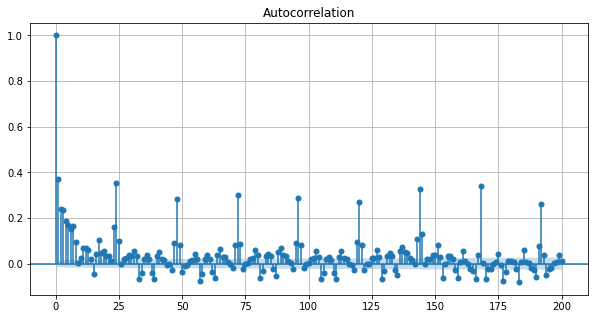

In [111]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(results.resid.dropna(), ax = ax, lags=200)
fig.savefig('AR_acf.png')
plt.show()

In [102]:
R2 = []
mse = []
expl_var = []

for store in data_edit:
    X = ['error', 'cust', 'emp', 'temp+', 'temp-', 'led', 'pvp', 'BMS']
    X1 = []
    for x in X:
        if len(data_edit[store].dropna()[x].unique()) > 1: #data_edit['store_'].dropna()
            X1.append(x)
    
    index0 = datetime.datetime(2020, 1, 1)
    for intervention in ['led', 'pvp', 'BMS']:
        if len(data_edit[store].dropna()[intervention].unique()) > 1:
            if index0 > data_edit[store][data_edit[store][intervention]==1].index[0]:
                index0 = data_edit[store][data_edit[store][intervention]==1].index[0]

    x = data_edit[store][data_edit[store].index<index0].dropna()[X1]
    y = data_edit[store][data_edit[store].index<index0].dropna()['kWh'].values
    
    model = AutoReg(y, [1, 2, 24, 7*24], exog=x)
    results = model.fit()
    #print(città, '\n', results.summary(), '\n\n')

    y=pd.Series(y)
    y.index = x.index
    yhat = results.fittedvalues
    y_true = y[168:]
    
    #if results.rsquared<0.7:
    #    print(store)
    #    print(results.rsquared)
    
    R2.append(r2_score(y_true, yhat))
    mse.append(mean_squared_error(y_true, yhat))
    expl_var.append(explained_variance_score(y_true, yhat))
    
print(np.median(R2), np.median(mse), np.median(expl_var))

0.937370655303746 397.43417051369465 0.937370655303746


# Autoregressivo